In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import math

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, concatenate, Input
from keras.losses import mean_squared_error
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator



import time

size_val = 512
testing_image =[]

In [24]:
import pickle

In [103]:
def train_model_fcn_vl(DataSet, start_lb, end_lb, train = True, test = False):

    [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label] = DataSet

    global testing_image
    testing_image = val_ds_img[0]

    epochs = 1500
    batch_size = 10

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = []
    tmp_train_img = []
    label_number = 14

    for lbs in range(len(train_ds_label)):
         if get_x_label_coordenates_exist(train_ds_label[lbs], label_number):
                tmp_train_img.append(train_ds_img[lbs])
                tmp_train_labels.append(train_ds_label[lbs])

    train_ds_img = np.array(tmp_train_img)
    train_ds_label = tmp_train_labels
    print("===== DETECTED " + str(train_ds_img.shape[0]) + " images that contains label no. " + str(label_number) + " =====")

    # Now make the trining datases using only the subset with that contain the "label_number" label
    print("Extracting patches")
    tmp_train_patch = []
    tmp_train_mask_patch = []
    for lbn in range(4, label_number):
    #for lbn in [label_number-1]:
    #for lbn in [3,label_number]:
        train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,lbn)
        train_lbs_tmp = np.array(train_lbs_tmp)

        train_lbs_tmp_mask = label2MaskMap(train_lbs_tmp, radius = 20, normalize = True)

        for i in range(train_ds_img.shape[0]):

            train_patch = []
            train_mask_patch = []
            train_patch_negative = []
            train_mask_patch_negative = []

            # Make patch
            dx = 15
            dy = 10

            x = train_lbs_tmp[i,0]
            y = train_lbs_tmp[i,1]
            org_shape =  train_ds_img[i, y - dy : y + dy, x - dx : x + dx, 0].shape
            if org_shape == (2 * dy,2 * dx):
                train_patch.append(train_ds_img[i, y - dy : y + dy, x - dx : x + dx, 0])
                train_mask_patch.append(train_lbs_tmp_mask[i, y - dy : y + dy, x - dx : x + dx])

            # generate negative patch for training
            import random
            random_num = random.randint(0,1)
            if random_num == 0: # left side of IVD selected randomly
                xr = random.randint(dx + 1, x - dx - 10)
                org_shape =  train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0].shape
                if org_shape == (2 * dy,2 * dx):
                    train_patch_negative.append(train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0])
                    train_mask_patch_negative.append(train_lbs_tmp_mask[i, y - dy : y + dy, xr - dx : xr + dx])
            else: # right side of IVD selected randomly
                xr = random.randint(x + dx + 10, x + dx + 30)
                org_shape =  train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0].shape
                if org_shape == (2 * dy,2 * dx):
                    train_patch_negative.append(train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0])
                    train_mask_patch_negative.append(train_lbs_tmp_mask[i, y - dy : y + dy, xr - dx : xr + dx])

            # add negative patch to the traiig list
            random_num = random.randint(0,100)
            if random_num < 60: #If do not work go to 50 ;)
                train_patch.extend(train_patch_negative)
                train_mask_patch.extend(train_mask_patch_negative)

            # getting the patch for all IVD
            tmp_train_patch.extend(train_patch)
            tmp_train_mask_patch.extend(train_mask_patch)


    train_patch = np.array(tmp_train_patch)
    train_mask_patch = np.array(tmp_train_mask_patch)
    train_patch = np.expand_dims(train_patch, axis=3)
    train_mask_patch = np.expand_dims(train_mask_patch, axis=3)
    #====DEBUG====
    print("====DEBUG====")
    print(train_patch.shape)
    print(train_mask_patch.shape)
    print("====DEBUG====")
    time.sleep(5)
    #====DEBUG====

    # Export groud truth
    import cv2
    image_cm = cv2.applyColorMap(np.array(train_mask_patch[0,:,:,0] * 255, dtype=np.uint8), cv2.COLORMAP_JET)
    img_out = array_to_img(image_cm)#, data_format='channels_first')
    img_out.save('./storage/h_gt_heatmap.png')

    # Export mask image
    img = train_patch[0,:,:,0]
    img = img  - np.amin(img)
    img = img * 255.0/np.amax(img)
    img = np.array(img, dtype=np.uint8)
    img= np.expand_dims(img, axis=3)
    img_out = array_to_img(img)#, data_format='channels_first')
    #img_out = array_to_img(np.expand_dims(np.array(train_patch[0,:,:,0] * 10, dtype=np.uint8), axis=3))#, data_format='channels_first')
    img_out.save('./storage/h_mask_image.png')



    # Keras Data Augmentation
    print('Data Augmentation: In progress')
    data_gen_args = dict(featurewise_center=False,
                         featurewise_std_normalization=False,
                         rotation_range=20.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.0,
                         horizontal_flip=False,
                         vertical_flip=False,
                         fill_mode="nearest")

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1

    image_datagen.fit(train_patch, augment=True, seed=seed)
    mask_datagen.fit(train_mask_patch, augment=True, seed=seed)

    steps_epoch = (train_patch.shape[0] // batch_size)
    image_generator = image_datagen.flow(train_patch, seed=seed, batch_size=batch_size)
    mask_generator = mask_datagen.flow(train_mask_patch, seed=seed, batch_size=batch_size)
    train_generator = zip(image_generator, mask_generator)
    # Recover x,y position from the mask
    #y, x = np.unravel_index(sample.argmax(), sample.shape)
    print('Data Augmentation: Done')



    # ==================
    # LOAD THE DL MODEL
    # ==================
    model = fcn_vl_v1()


    
    model.summary()

    # best results Adam_e-7_e-10_DA
    lr = 5e-7
    minimum_lr = 1e-10

    model.compile(loss=caffe_eucl_loss,
                  # optimizer=keras.optimizers.Adadelta(),
                  optimizer=keras.optimizers.Adam(lr= lr),
                  #optimizer=keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=False),
                  metrics=[])



    # Keras Callbacks

    # checkpoint
    model_filepath = "./fcn_VL_IVD_" +str(lbn)+ "_weights.best.hdf5"
    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor='loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 save_weights_only=True)

    early_stop = EarlyStopping(monitor="loss",
                               min_delta=0.001,
                               patience=500,
                               verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='loss',
                                  factor=0.5,
                                  patience=30,
                                  min_lr=minimum_lr,
                                  verbose=1)

    tboard = TensorBoard(log_dir='./Graph', histogram_freq=0,
                         write_graph=False, write_grads=False,
                         write_images=False, embeddings_freq=0,
                         embeddings_layer_names=None,
                         embeddings_metadata=None)

    heatMap_gen = Generate_Big_HeatMap()


    model.fit_generator(train_generator,
                        steps_per_epoch=steps_epoch,
                        max_q_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        #validation_data=(val_ds_img, val_lbs_tmp_mask),
                        callbacks=[early_stop, reduce_lr, checkpoint, heatMap_gen])

    K.clear_session()

In [102]:
def fcn_vl_v3():
    # Too heavy
    input_shape = (None, None, 1)
    input_img = Input(shape=input_shape)

    fn_L1 = 32 # features number
    L1_DCov_1 = Conv2D(fn_L1, kernel_size=(1, 1),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_2 = Conv2D(fn_L1, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_3 = Conv2D(fn_L1, kernel_size=(3, 3),
                       dilation_rate=(2, 2),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_4 = Conv2D(fn_L1, kernel_size=(3, 3),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_5 = Conv2D(fn_L1, kernel_size=(3, 3),
                       dilation_rate=(4, 4),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_concat = concatenate([L1_DCov_1,
                             L1_DCov_2,
                             L1_DCov_3,
                             L1_DCov_4,
                             L1_DCov_5,])

    L1_concat = Conv2D(32, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)

    #L1_concat = Dropout(0.5)(L1_concat)

    fn_L2 = 32
    L2_DCov_1 = Conv2D(fn_L2, kernel_size=(1, 1),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_2 = Conv2D(fn_L2, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_3 = Conv2D(fn_L2, kernel_size=(3,3),
                       dilation_rate=(2, 2),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_4 = Conv2D(fn_L2, kernel_size=(3, 3),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_5 = Conv2D(fn_L2, kernel_size=(5, 5),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)

    L2_concat = concatenate([L2_DCov_1,
                             L2_DCov_2,
                             L2_DCov_3,
                             L2_DCov_4,
                             L2_DCov_5])

    L2_concat = Conv2D(32, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)

    #L2_concat = Dropout(0.5)(L2_concat)

    fn_L3 = 32
    L3_DCov_1 = Conv2D(fn_L3, kernel_size=(1, 1),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_2 = Conv2D(fn_L3, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_3 = Conv2D(fn_L3, kernel_size=(3, 3),
                       dilation_rate=(2, 2),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_4 = Conv2D(fn_L3, kernel_size=(3, 3),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_5 = Conv2D(fn_L3, kernel_size=(5, 5),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)

    L3_concat = concatenate([L3_DCov_1,
                             L3_DCov_2,
                             L3_DCov_3,
                             L3_DCov_4,
                             L3_DCov_5])

    L4 = Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         strides=1,
                         padding='same',
                         name="relu")(L3_concat)

    #L4 = Dropout(0.5)(L4)

    predictions = Conv2D(1, kernel_size=(3, 3),
                         activation='sigmoid',
                         strides=1,
                         padding='same',
                         name="predictions")(L4) #test sigmoid

    model = Model(inputs= [input_img], outputs=predictions)
    return model

def fcn_vl_v1():
    # Too heavy
    input_shape = (None, None, 1)
    input_img = Input(shape=input_shape)

    fn_L1 = 32 # features number
    L1_DCov_1 = Conv2D(fn_L1, kernel_size=(5, 5),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_2 = Conv2D(fn_L1, kernel_size=(10, 10),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_3 = Conv2D(fn_L1, kernel_size=(10, 10),
                       dilation_rate=(2, 2),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_4 = Conv2D(fn_L1, kernel_size=(10, 10),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_DCov_5 = Conv2D(fn_L1, kernel_size=(10, 10),
                       dilation_rate=(4, 4),
                       activation='relu',
                       strides=1,
                       padding='same',
                       input_shape=input_shape)(input_img)
    L1_concat = concatenate([L1_DCov_1,
                             L1_DCov_2,
                             L1_DCov_3,
                             L1_DCov_4,
                             L1_DCov_5,])

    L1_concat = Conv2D(32, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)

    #L1_concat = Dropout(0.5)(L1_concat)

    fn_L2 = 32
    L2_DCov_1 = Conv2D(fn_L2, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_2 = Conv2D(fn_L2, kernel_size=(5, 5),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_3 = Conv2D(fn_L2, kernel_size=(5,5),
                       dilation_rate=(2, 2),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_4 = Conv2D(fn_L2, kernel_size=(5, 5),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)
    L2_DCov_5 = Conv2D(fn_L2, kernel_size=(10, 10),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L1_concat)

    L2_concat = concatenate([L2_DCov_1,
                             L2_DCov_2,
                             L2_DCov_3,
                             L2_DCov_4,
                             L2_DCov_5])

    L2_concat = Conv2D(32, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)

    #L2_concat = Dropout(0.5)(L2_concat)

    fn_L3 = 32
    L3_DCov_1 = Conv2D(fn_L3, kernel_size=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_2 = Conv2D(fn_L3, kernel_size=(5, 5),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_3 = Conv2D(fn_L3, kernel_size=(5, 5),
                       dilation_rate=(2, 2),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_4 = Conv2D(fn_L3, kernel_size=(5, 5),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)
    L3_DCov_5 = Conv2D(fn_L3, kernel_size=(10, 10),
                       dilation_rate=(3, 3),
                       activation='relu',
                       strides=1,
                       padding='same')(L2_concat)

    L3_concat = concatenate([L3_DCov_1,
                             L3_DCov_2,
                             L3_DCov_3,
                             L3_DCov_4,
                             L3_DCov_5])

    L4 = Conv2D(32, kernel_size=(3, 3),
                         activation='relu',
                         strides=1,
                         padding='same',
                         name="relu")(L3_concat)

    #L4 = Dropout(0.5)(L4)

    predictions = Conv2D(1, kernel_size=(3, 3),
                         activation='sigmoid',
                         strides=1,
                         padding='same',
                         name="predictions")(L4) #test sigmoid

    model = Model(inputs= [input_img], outputs=predictions)
    return model

In [29]:
# Pipeline for IVD detection using deep learning.
# 1 - Fix that IVD is the one that will be detected
# 2 - Get the paths list of all the images and labels that will be used
# 3 - Do a random sort to mix all images
# 4 - Save the random sort
# 5 - Get all the images that have the specified label
# 6 - run the models (input np. img np.labels, output pandas object)
# 7- show the results using violinplots
#
# author: Francisco Perdigon Romero
# Neuropoly

import os
import NeuroPoly_Datasets.VL_Dataset as vlds

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

import time
import cPickle as pickle

store_folder = 'fcn_VL/'

def load_Data(DataSet_path):
    size_val = 512
    fname_TXT = 'fnames_less_512.txt'

    if os.path.exists(fname_TXT) == False:
        bof = vlds.get_dataset_folders(DataSet_path)
        [im_resampled, lb_resampled, im_sagittal] = vlds.get_NIFTI_type(bof, 4)
        fname_list_under_512 = vlds.get_Img_max_size(im_sagittal, px_max=size_val)
        [shuffled_img, shuffled_lbs] = vlds.shuffle_data(fname_list_under_512, fname_list_under_512)
        vlds.save_NIFTI_images_list_to_text_file(shuffled_img, fname_TXT)
    else:
        shuffled_img = vlds.load_NIFTI_images_list_from_test_file(fname_TXT)

    data_dir_list = vlds.get_parent_folder_from_NIFTI_file(shuffled_img)

    load_pkl = True

    if load_pkl == False:

        [im_resampled, lb_resampled, im_sagittal] = vlds.get_NIFTI_type(data_dir_list, 4)
        labels_fname_list = lb_resampled

        labels_fname_list = vlds.get_data_containing_label_range(labels_fname_list, start_lb,end_lb + 1)

        print('The size of the dataset is %i' % (len(labels_fname_list)))
        data_dir_list = vlds.get_parent_folder_from_NIFTI_file(labels_fname_list)
        [train_ds, val_ds, test_ds] = vlds.splitDataset(data_dir_list, train=80, val=10, test=10)
        print('The size of the training dataset is %i' % (len(train_ds)))
        print('The size of the validation dataset is %i' % (len(val_ds)))
        print('The size of the test dataset is %i' % (len(test_ds)))
        [train_im_resampled, train_lb_resampled, train_im_sagittal_flatten] = vlds.get_NIFTI_type(train_ds, 4)
        [val_im_resampled, val_lb_resampled, val_im_sagittal_flatten] = vlds.get_NIFTI_type(val_ds, 4)
        [test_im_resampled, test_lb_resampled, test_im_sagittal_flatten] = vlds.get_NIFTI_type(test_ds, 4)

        vlds.save_NIFTI_images_list_to_text_file(train_im_sagittal_flatten, store_folder + "train_set.txt")
        vlds.save_NIFTI_images_list_to_text_file(val_im_sagittal_flatten, store_folder + "val_set.txt")
        vlds.save_NIFTI_images_list_to_text_file(test_im_sagittal_flatten, store_folder + "test_set.txt")

        # Load Images and labels
        train_ds_img = vlds.get_mid_sagittal_slice_2_list_of_np_array(train_im_sagittal_flatten)
        train_ds_label = vlds.get_labels_values_list(train_lb_resampled)
        val_ds_img = vlds.get_mid_sagittal_slice_2_list_of_np_array(val_im_sagittal_flatten)
        val_ds_label = vlds.get_labels_values_list(val_lb_resampled)
        test_ds_img = vlds.get_mid_sagittal_slice_2_list_of_np_array(test_im_sagittal_flatten)
        test_ds_label = vlds.get_labels_values_list(test_lb_resampled)

        with open(store_folder + 'train_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(train_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'train_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(train_ds_label, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'val_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(val_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'val_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(val_ds_label, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'test_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(test_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'test_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(test_ds_label, output, pickle.HIGHEST_PROTOCOL)

    else:

        with open(store_folder + 'train_ds_img.pkl', 'rb') as input:
            train_ds_img = pickle.load(input,encoding='latin1')
        with open(store_folder + 'train_ds_label.pkl', 'rb') as input:
            train_ds_label = pickle.load(input)
        with open(store_folder + 'val_ds_img.pkl', 'rb') as input:
            val_ds_img = pickle.load(input)
        with open(store_folder + 'val_ds_label.pkl', 'rb') as input:
            val_ds_label = pickle.load(input)
        with open(store_folder + 'test_ds_img.pkl', 'rb') as input:
            test_ds_img = pickle.load(input)
        with open(store_folder + 'test_ds_label.pkl', 'rb') as input:
            test_ds_label = pickle.load(input)

    # Normalize images
    train_ds_img = vlds.images_normalization(train_ds_img)
    val_ds_img = vlds.images_normalization(val_ds_img)
    test_ds_img = vlds.images_normalization(test_ds_img)

    # Zero padding
    train_ds_img = vlds.add_zero_padding(train_ds_img, x_val=size_val, y_val=size_val)
    val_ds_img = vlds.add_zero_padding(val_ds_img, x_val=size_val, y_val=size_val)
    test_ds_img = vlds.add_zero_padding(test_ds_img, x_val=size_val, y_val=size_val)

    # Convert images to np.array
    train_ds_img = np.array(train_ds_img)
    val_ds_img = np.array(val_ds_img)
    test_ds_img = np.array(test_ds_img)

    return [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label]

def generate_violinplots(np_data, description ):
    # Process the results and store in Panda objects
    col = []
    for i in range(start_lb, end_lb + 1):
        col.append(vlds.label_2_IVSpace(i))

    loss_val_np = np.rot90(np_data)
    pd_df = pd.DataFrame.from_records(loss_val_np, columns=col)

    # Set up the matplotlib figure using Seaborn
    f, ax = plt.subplots(figsize=(11, 6))

    ax = sns.violinplot(data=pd_df, palette="Set3", bw=.2, cut=1, linewidth=1)
    ax = sns.swarmplot(data=pd_df, color="royalblue")
    ax.set(xlabel='Error distribution', ylabel='L2 error(mm)')
    ax = sns.despine(left=True, bottom=True)

    plt.savefig(store_folder + 'violinplot_jca' + info + description + '.png')

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 6))

    ax = sns.violinplot(data=pd_df, palette="Set3", bw=.2, cut=1, linewidth=1)
    ax.set(xlabel='Error distribution', ylabel='L2 error(mm)')
    ax = sns.despine(left=True, bottom=True)

    plt.savefig(store_folder + 'violinplot_fco' + info + description + '.png')

def visualize_labels(Image_list,loss_predictions, save_img = False, name_img = "train_"):
    """
    loss_predictions extructure {Labels{images{lbs, predictions, loss}}}

    :param Image_list:
    :param loss_predictions:
    :return:
    """
    global store_folder
    global info
    global start_lb
    global end_lb

    print("Saving images and labels (" + name_img + ") to PNG")

    for i in range(0, Image_list.shape[0]):

        plt.imshow(Image_list[i,:,:,0], 'gray')
        # plot labels
        for j in range(start_lb, end_lb + 1):
            lbs = loss_predictions[j-start_lb,i,0]
            gt_color = 'yellow'
            gt = plt.plot(lbs[0], lbs[1], 'o', markersize=2, color=gt_color)
            plt.text(lbs[0] + 7, lbs[1], str(j), {'color': gt_color, 'fontsize': 4})

            pred_lbs = loss_predictions[j-start_lb,i,1]
            pred_color = 'cornflowerblue'
            de = plt.plot(pred_lbs[0], pred_lbs[1], marker='+', markersize=3, color=pred_color, mew=1)
            plt.text(pred_lbs[0] - 13, pred_lbs[1], str(j), {'color': pred_color, 'fontsize': 4})

            plt.legend((gt[0], de[0]), ('Ground truth', 'Detected'),
                       loc=2, fontsize=4)

            plt.axis([0, Image_list[i].shape[1], Image_list[i].shape[0], 0])
            plt.axis("off")
            plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

        if save_img == False:
            plt.show(block = True)
        else:
            plt.show(block=False)

        if save_img == True:
            numb_prefix = ""
            if i < 10:
                numb_prefix = "_000"
            elif i < 100 and i > 9:
                numb_prefix = "_00"
            elif i < 1000 and i > 99:
                numb_prefix = "_0"
            elif i > 1000:
                numb_prefix = "_"

            plt.savefig(store_folder + name_img + info + numb_prefix + str(i) + '.png',
                        bbox_inches='tight', pad_inches=0, dpi = 300)

        plt.close()


if __name__ == "__main__":
    starting_time = time.time()


    info = '_fcn_vl_model_v1_'

    start_lb = 7
    end_lb = 7

    DataSet_path = './Database/PolyDatabase_2/'
    #DataSet_path ='/Users/fperdigon_admin/Documents/PyCharm/deep_vl_LOCAL/Database/PolyDatabase_2/'

    # Load Data
    DataSet = load_Data(DataSet_path)

    # Train / Test the model
    #fcn_vl.train_model_fcn_vl(DataSet, start_lb, end_lb)
    fcn_vl.deploy_model_fcn_vl(DataSet)


    #deploy_results = fcn_vl.deploy_model_fcn_vl(DataSet, start_lb, end_lb, val=True, test=True)
    # Dimesion order: {val/test{Labels {images{val_lbs, predictions, loss}}}}
    # Save the prediction and validate loss values

    #with open(store_folder + 'loss_predictions' + info+ '.pkl', 'wb') as output:  # Overwrites any existing file.
    #    pickle.dump(deploy_results, output, pickle.HIGHEST_PROTOCOL)

    #[loss_predictions_val, loss_predictions_test] = deploy_results
    #loss_predictions_val = np.array(loss_predictions_val)
    #loss_predictions_test = np.array(loss_predictions_test)

    # Save the loss to CVS file
    #t1 = np.rot90(loss_predictions_val[:, :, 2])
    #t2 = np.rot90(loss_predictions_test[:, :, 2])
    #np.savetxt(store_folder + 'validation_loss.csv', t1, delimiter=';')
    #np.savetxt(store_folder + 'test_loss.csv', t2, delimiter=';')

    # Visualize and save labels
    #[train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label] = DataSet
    #visualize_labels(val_ds_img, loss_predictions_val, save_img=True, name_img="validation")
    #visualize_labels(test_ds_img, loss_predictions_test, save_img=True, name_img="test")

    # Generate loss violinplots
    #sns.set(style="whitegrid")
    #generate_violinplots(loss_predictions_val[:,:,2], "_validation")
    #generate_violinplots(loss_predictions_test[:,:,2], "_test")

    # Print the training time
    elapsed_time = time.time () - starting_time
    elapsed_time = int(elapsed_time)
    elapsed_time_minutes = int(elapsed_time / 60)
    elapsed_time_seconds = elapsed_time % 60

    print('Elapsed time: %i minutes' %(elapsed_time_minutes))


ModuleNotFoundError: No module named 'NeuroPoly_Datasets'

In [27]:
# !/usr/bin/env python
#
# Prepare an homogeneous Dataset for training
# This code contains useful functions to create
# a dataset from the nifti images and labels
#
# author: Francisco Perdigon Romero
# Neuropoly

import os
import subprocess
import numpy as np

import sys

#sys.path.append('spinalcordtoolbox/scripts/')
#sys.path.append('/home/fperdigon_local/spinalcordtoolbox/scripts/')
#from spinalcordtoolbox.image import Image
sys.path.insert(0, '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/')
print(sys.path)
import spinalcordtoolbox.image as Image

from skimage.morphology import square
from skimage.morphology import dilation
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

Poly_DataSet_path = '../Database/PolyDatabase_2/'
labels_orginal_fname = 'labels_disc_all_posterior.nii.gz'
labels_resampled_fname = 'labels_disc_all_posterior_r.nii.gz'
labels_dilated_fname = 'labels_disc_all_posterior_dilated.nii.gz'
sagittal_flatten_fname = 'flatten_sag.nii.gz'


IVSpace_order = ['APMJ', 'PMJ', 'Top C1', 'C2-C3', 'C3-C4', 'C4-C5', 'C5-C6', 'C6-C7', 'C7-T1',
             'T1-T2', 'T2-T3', 'T3-T4', 'T4-T5', 'T5-T6', 'T6-T7',
             'T7-T8', 'T8-T9', 'T10-T11', 'T11-T12', 'T12-L1',
             'L1-L2', 'L2-L3', 'L3-L4', 'L4-L5', 'L5-S1',
             'S1-S2', 'S2-S3', 'S3-S4', 'S4-S5']


def get_dataset_folders(Poly_DataSet_path = Poly_DataSet_path):
    '''
    Returns the path of where the NIFI files are
    It is assumed that the files are in the form duke: sct_testing/large/
    :param Poly_DataSet_path:
    :return:
    '''

    lf = os.listdir(Poly_DataSet_path)
    folders_list_nifti = []

    for f in lf:
        if f.startswith('.') == False and f.startswith('_') == False:
            for sf in os.listdir(Poly_DataSet_path + '/' + f):
                if sf.startswith('.') == False:
                    folders_list_nifti.append(Poly_DataSet_path + '/' + f + '/' + sf)
    return folders_list_nifti

def load_NIFTI_images_list_from_test_file(text_fname):
    '''
    Returns in a python list the files that are in a text file.
    The existence of the files is checked, if the files do not exist
    they are not included in the returned list
    :param text_fname: file path, the file contains a list of paths of images
    :return img_fname_list:
    '''
    file = open(text_fname, 'r')
    fileslist = file.readlines()
    file.close()
    img_fname_list = []
    for i in range(len(fileslist)):
        fileslist[i] = str.split(fileslist[i], '\n')[0]
        if os.path.exists(fileslist[i]):
            img_fname_list.append(fileslist[i])
        else:
            print('The file does not exist')
            print(fileslist[i])
    return img_fname_list

def save_NIFTI_images_list_to_text_file(fname_list, text_fname):

    file = open(text_fname, 'w')
    for i in range(len(fname_list)):
        file.write(fname_list[i] + '\n')
    file.close()

def get_parent_folder_from_NIFTI_file(fileslist):
    '''
    This function returns a list of the parent folder of the NIFTI files
    :param fileslist:
    :return:
    '''
    if type(fileslist) != list:
        fileslist = [fileslist]

    main_folders = []
    for f in fileslist:
        main_folders.append(os.path.dirname(os.path.abspath(f)))
    return main_folders

def get_NIFTI_type(folder_list, NIFTI_type):
    '''
    This function returns the existing elements of the
    NIFTI file type (NIFTI_type) contained in the folders (folder_list) \n
    :param folder_list: list of folders \n
    :param NIFTI_type: int \n
                       0 images in original resolution (ex: t2.nii.gz) \n
                       1 images resampled (ex: t2_r.nii.gz) \n
                       2 images sagittal flatten (ex: flatten_sag.nii.gz) \n
                       3 labels in original resolution (ex: labels_disc_all_posterior.nii.gz)\n
                       4 labels resampled (ex: labels_disc_all_posterior_r.nii.gz) \n
    :return:
    '''
    global sagittal_flatten_fname
    global labels_orginal_fname
    global labels_resampled_fname

    if type(folder_list) != list:
        folder_list = [folder_list]

    images_list_out = []
    labels_list_out = []
    sagittal_flatten_list_out = []
    out = []

    for f in folder_list:
        if NIFTI_type == 0: # 0 images in original resolution
            im_fname = f + '/' + str.split(f, '/')[-1] + '.nii.gz'
            if os.path.exists(im_fname):
                images_list_out.append(im_fname)
            else:
                print('ERROR, the file does not exist')
                print(im_fname)

        if NIFTI_type == 1: # 1 images resampled
            im_fname = f + '/' + str.split(f, '/')[-1] + '_r.nii.gz'
            if os.path.exists(im_fname):
                images_list_out.append(im_fname)
            else:
                print('ERROR, the file does not exist')
                print(im_fname)

        if NIFTI_type == 2: # 2 images sagittal flatten
            im_fname = f + '/' + sagittal_flatten_fname
            if os.path.exists(im_fname):
                images_list_out.append(im_fname)
            else:
                print('ERROR, the file does not exist')
                print(im_fname)

        if NIFTI_type == 3: # 3 labels in original resolution
            im_fname = f + '/' + str.split(f, '/')[-1] + '.nii.gz'
            lb_fname = f + '/' + labels_orginal_fname

            if os.path.exists(im_fname) and os.path.exists(lb_fname):
                images_list_out.append(im_fname)
                labels_list_out.append(lb_fname)
            else:
                print('ERROR, one of these files does not exist')
                print(im_fname)
                print(lb_fname)

        if NIFTI_type == 4:  # 4 labels resampled
            im_fname = f + '/' + str.split(f, '/')[-1] + '_r.nii.gz'
            lb_fname = f + '/' + labels_resampled_fname
            sf_fname = f + '/' + sagittal_flatten_fname

            if os.path.exists(im_fname) and os.path.exists(lb_fname):
                images_list_out.append(im_fname)
                labels_list_out.append(lb_fname)
                if os.path.exists(sf_fname):
                    sagittal_flatten_list_out.append(sf_fname)
                else:
                    sagittal_flatten_list_out.append('')
            else:
                print('ERROR, one of these files does not exist')
                print(im_fname)
                print(lb_fname)



        if NIFTI_type < 3:
            out = images_list_out
        elif NIFTI_type == 3:
            out = [images_list_out, labels_list_out]
        elif NIFTI_type == 4:
            out = [images_list_out, labels_list_out, sagittal_flatten_list_out]

    return out

def resample_nifti_images_SCT(files_list_nifti_img, resolution_mm ='1x1x1'):
    if type(files_list_nifti_img) != list:
        files_list_nifti_img = [files_list_nifti_img]
    for i in range(len(files_list_nifti_img)):
        print('Resizing subset %i of %i' %(i+1, len(files_list_nifti_img)))
        p = subprocess.Popen(['sct_resample', '-i', files_list_nifti_img[i], '-mm', resolution_mm, '-x', 'linear'],
                             stdout=subprocess.PIPE)
        p.wait()
    print('Done, %i images where resized' %(len(files_list_nifti_img)))

def dilate_labels_size(lb_fname_list):
    '''
    These function dilate the labels becauste some labels can be lost during the resample proccess
    :param lb_fname:
    :return:
    '''

    if type(lb_fname_list) != list:
        lb_fname_list = [lb_fname_list]

    for i in range(len(lb_fname_list)):
        print('Processing %i of %i' % (i + 1, len(lb_fname_list)))
        im_label = Image(lb_fname_list[i])
        im_label_original_orientation = im_label.orientation
        im_label.change_orientation(orientation='SAL')
        im_label.data = im_label.data.astype(int)

        im_label_dilated_data = np.zeros(im_label.data.shape, dtype=im_label.data.dtype)

        for LR_axis in range(im_label.data.shape[-1]):
            im_label_dilated_data[:, :, LR_axis] = dilation(im_label.data[:,:,LR_axis], square(5))

        im_label_dilated = im_label.copy()
        im_label_dilated.orientation = 'SAL'
        im_label_dilated.data = im_label_dilated_data
        im_label_dilated.change_orientation(orientation=im_label_original_orientation)
        lb_dilated_fname = str.split(lb_fname_list[i],'.nii.gz')[0] + '_dilated.nii.gz'
        im_label_dilated.setFileName(lb_dilated_fname)
        im_label_dilated.save()
    print ('Done, %i labels files dilated' %(len(lb_fname_list)))

def resample_nifti_labels_SCT(files_list_nifti_labels, resolution_mm ='1x1x1', dilate = True):
    global labels_dilated_fname
    global labels_resampled_fname
    if type(files_list_nifti_labels) != list:
        files_list_nifti_labels = [files_list_nifti_labels]

    for i in range(len(files_list_nifti_labels)):
        print('Resample label %i of %i' % (i + 1, len(files_list_nifti_labels)))

        if dilate: # dilate
            dilate_labels_size(files_list_nifti_labels[i])

        fn = get_parent_folder_from_NIFTI_file(files_list_nifti_labels[i])[0] + '/' + labels_dilated_fname
        fn_out = get_parent_folder_from_NIFTI_file(files_list_nifti_labels[i])[0] + '/' + labels_resampled_fname
        # resample
        p = subprocess.Popen(['sct_resample', '-i', fn, '-mm', resolution_mm, '-x', 'nn', '-o', fn_out],
                             stdout=subprocess.PIPE)
        p.wait()

        # delete dilated label file
        p = subprocess.Popen(['rm', fn],
                             stdout=subprocess.PIPE)
        p.wait()

        p = subprocess.Popen(['sct_label_utils', '-i', fn_out, '-cubic-to-point', '-o', fn_out],
                             stdout=subprocess.PIPE)
        p.wait()
    print('Done, %i labels where resized' %(len(files_list_nifti_labels)))

def set_orient_data_SCT(files_list, fov ='AIL'): #AIL

    for i in range(len(files_list)):
        print('Changing FOV subset %i of %i' % (i+1, len(files_list)))
        p = subprocess.Popen(['sct_image', '-i', files_list[i], '-setorient', fov],
                             stdout=subprocess.PIPE)
        p.wait()

    print('Done, FOV Changed for %i NIFTI files' % (len(files_list)))

def sagittal_flatten_SCT(files_list_nifti_img):

    for i in range(len(files_list_nifti_img)):
        print('Processing %i of %i' % (i+1, len(files_list_nifti_img)))

        # Get center line
        # using OptiC Method
        print('Getting centerline')
        p = subprocess.Popen(['sct_get_centerline', '-i', files_list_nifti_img[i], '-c', 't2'],
                             stdout=subprocess.PIPE)
        p.wait()
        print('Done')

        print('Doing Sagittal flatten')
        file_name_centerline = str.split(files_list_nifti_img[i], '/')[-1]
        file_name_centerline = str.split(file_name_centerline, '.nii.gz')[0] + '_centerline_optic.nii.gz'
        try:
            flatten_sagittal(files_list_nifti_img[i], file_name_centerline)
            print('Done')

        except:
            print('ERROR')
            files_list_nifti_img[i]

def flatten_sagittal(fname_im_anat, fname_centerline):
    import sys
    sys.path.append('/Users/fperdigon_admin/Documents/spinalcordtoolbox/scripts/')
    from msct_image import Image
    from sct_image import get_orientation_3d, set_orientation
    import numpy as np


    im_anat = Image(fname_im_anat)
    anat_ima_orientation_original = get_orientation_3d(im_anat)
    im_centerline = Image(fname_centerline)


    # Reorient input data into RL PA IS orientation
    im_anat.change_orientation(orientation='RPI')

    im_centerline.change_orientation(orientation='RPI')

    X = np.zeros(im_centerline.data.shape[-1], dtype=np.int16)
    Y = np.zeros(im_centerline.data.shape[-1], dtype=np.int16)
    for z_axis in range(im_centerline.data.shape[-1]):
        X[z_axis], Y[z_axis] = im_centerline.data[:, :, z_axis].nonzero()

    im_x, im_y, im_z = im_anat.data.shape

    imf_x = 2 * im_x + 1 # With these value for sure the loop will not trespass the max index

    im_flatten_sag_data = np.zeros((imf_x, im_y, im_z), dtype=im_anat.data.dtype)

    for z_axis in range(len(X)):
        x_start = int(imf_x/2) - X[z_axis]
        x_end = x_start + im_x
        im_flatten_sag_data[x_start : x_end,:,z_axis] = im_anat.data[:,:,z_axis]

    import os
    im_anat_dir = os.path.dirname(os.path.abspath(fname_im_anat))

    im_flatten_sag = im_anat.copy()
    im_flatten_sag.orientation = 'RPI'
    im_flatten_sag.data = im_flatten_sag_data
    im_flatten_sag.change_orientation(orientation=anat_ima_orientation_original)
    im_flatten_sag.setFileName(im_anat_dir + '/flatten_sag.nii.gz')
    im_flatten_sag.save()

    print('Sagittal flatten saved on: ' + im_anat_dir + '/flatten_sag.nii.gz')

def shuffle_data(img_files_list, lab_files_list):
    # Shuffle the data
    indx = range(img_files_list.__len__())
    np.random.shuffle(indx)

    # Print the indx to save for latter get the same train schema
    # print(indx)

    ifpl = []
    lfpl = []

    for i in range(len(img_files_list)):
        ifpl.append(img_files_list[indx[i]])
        lfpl.append(lab_files_list[indx[i]])
    return [ifpl, lfpl]

def viewer_images_labels(iml, lbl, check_images = False, start = 0, pause_time = 0.5, figure_block =False, labels_color = 'r'):

    fig = plt.figure()

    for i in range(start,len(iml)):

        print(str(i + 1) + '/' + str(len(iml)))
        print(iml[i])
        im = Image(iml[i])
        im.change_orientation(orientation='SAL')
        lb = get_labels_value(lbl[i])

        mid_sag_plane = im.data.shape[-1]/2
        plt.imshow(im.data[:, :, mid_sag_plane], 'gray')
        for j in range(len(lb)):
            plt.plot(lb[j][0], lb[j][1], labels_color + 'o')
            plt.text(lb[j][0] + 5, lb[j][1], str(lb[j][3]) , {'color': labels_color, 'fontsize': 12})

        plt.axis([0, im.data[:, :, mid_sag_plane].shape[1], im.data[:, :, mid_sag_plane].shape[0], 0])
        plt.pause(pause_time)

        plt.show(block=figure_block)

        if check_images == True:
            print('The image or labels are OK?(y/n)')
            input = str(raw_input('Input:'))

            if input == 'y':
                text_file_OK = open("_OK.txt", "a")
                text_file_OK.write(iml[i] + '\n')
                text_file_OK.close()
            else:
                text_file_BAD = open("_BAD.txt", "a")
                text_file_BAD.write(iml[i] + '\n')
                text_file_BAD.close()

        fig.clear()

def make_Labels_annotation_from_list(fileslist, label_fname, start = 1):
    if type(fileslist) != list:
        fileslist = [fileslist]

    for i in range(start-1, len(fileslist)):
        print('Processing %i of %i' % (i + 1, len(fileslist)))
        print(fileslist[i])


        file_dir = os.path.dirname(os.path.abspath(fileslist[i]))
        file_out = file_dir + '/' + label_fname
        p = subprocess.Popen(['sct_label_utils', '-i', fileslist[i], '-create-viewer', '50, 49, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32', '-o', file_out ],
                             stdout=subprocess.PIPE)
        p.wait()
        print('Done')

def get_Img_max_size(img_fname_list, px_max=512):

    img_fname_list_out = []

    for i in range(len(img_fname_list)):

        im = Image(img_fname_list[i])
        im.change_orientation(orientation='SAL')

        mid_sag_slice = im.data.shape[-1]/2
        mid_sag_plane = im.data[:, :, mid_sag_slice]

        print(str(i + 1) + ';' + img_fname_list[i] + ';' + str(mid_sag_plane.shape[0]) + ';' + str(mid_sag_plane.shape[1]))

        if mid_sag_plane.shape[0] <= px_max and mid_sag_plane.shape[1] <= px_max:
            img_fname_list_out.append(img_fname_list[i])

    return img_fname_list_out

def splitDataset(img_fname_list, train =60, val = 20, test = 20):
    ds_size = len(img_fname_list)
    train_ds = img_fname_list[0:int(ds_size*(train/100.0))]
    val_ds = img_fname_list[int(ds_size*(train/100.0)) : int(ds_size*(train/100.0)) + int(ds_size*(val/100.0))]
    test_ds = img_fname_list[int(ds_size*(train/100.0)) + int(ds_size*(val/100.0)) : -1 ]
    return [train_ds, val_ds, test_ds]

def get_data_containing_x_label(lbs_fname_list, label_number):

    ll = []

    for i in range(len(lbs_fname_list)):
        print('Looking for desired labels %i of %i' % (i + 1, len(lbs_fname_list)))
        lb_list = get_labels_value(lbs_fname_list[i])
        for lbs in range(len(lb_list)):
            if lb_list[lbs][3] == label_number:
                ll.append(lbs_fname_list[i])

    return ll

def get_data_containing_label_range(lbs_fname_list, label_start, label_end):
    """"
    These function search the images that contains all the labels in a range.
    For now only work on IVD labels, no APMJ(49) or PMJ(50)
    """

    ll = []

    for i in range(len(lbs_fname_list)):
        print('Looking for desired labels %i of %i' % (i + 1, len(lbs_fname_list)))
        lb_list = get_labels_value(lbs_fname_list[i])
        c = 0
        for lbs in range(len(lb_list)):
            for j in range(label_start, label_end):
                if lb_list[lbs][3] == j:
                    c = c + 1
        if c == label_end - label_start:
            ll.append(lbs_fname_list[i])

    return ll

def get_print_label_info(lbs_fname_list):

    for i in range(len(lbs_fname_list)):

        lbs_list = get_labels_value(lbs_fname_list[i])
        lb_min = 48
        lb_max = 0

        lb_50_flag = False
        lb_49_flag = False
        for ll in range(len(lbs_list)):
            for l in range(len(lbs_list)):

                if lbs_list[l][3] == 50:
                    lb_50_flag = True
                if lbs_list[l][3] == 49:
                    lb_49_flag = True
                if lbs_list[l][3] < lb_min:
                    lb_min = lbs_list[l][3]
                if lbs_list[l][3] > lb_max and lbs_list[l][3] != 50 and lbs_list[l][3] != 49:
                    lb_max = lbs_list[l][3]

        print(lbs_fname_list[i] + ';' + str(lb_min) + ';' + str(lb_max) + ';' + str(lb_50_flag) + ';' + str(lb_49_flag))


# Data Image oriented
def get_mid_sagittal_slice_2_list_of_np_array(img_NIFTI_fnames):

    if type(img_NIFTI_fnames) != list:
        img_NIFTI_fnames = [img_NIFTI_fnames]

    img_list = []
    for i in range(len(img_NIFTI_fnames)):

        print('Extracting mid sagittal plane ' + str(i + 1) + '/' + str(len(img_NIFTI_fnames)))

        im = Image(img_NIFTI_fnames[i])
        im.change_orientation(orientation='SAL')

        mid_sag_plane = im.data.shape[-1]/2
        img_list.append(im.data[:, :, mid_sag_plane])

    return img_list

def images_normalization(img_list, std = True):
    if type(img_list) != list:
        img_list = [img_list]
    img_norm_list = []
    for i in range(len(img_list)):
        #print('Normalizing ' + str(i + 1) + '/' + str(len(img_list)))
        img = img_list[i] - np.mean(img_list[i])  # zero-center
        if std:
            img_std = np.std(img)  # normalize
            epsilon = 1e-100
            img = img / (img_std + epsilon)  # epsilon is used in order to avoid by zero division
        img_norm_list.append(img)
    return img_norm_list

def add_zero_padding(img_list, x_val = 512, y_val=512):
    if type(img_list) != list:
        img_list = [img_list]
    img_zero_padding_list = []
    for i in range(len(img_list)):
        #print('Doing zero-padding ' + str(i + 1) + '/' + str(len(img_list)))
        img = img_list[i]
        img_tmp = np.zeros((x_val, y_val,1), dtype=np.float64)
        img_tmp[0:img.shape[0], 0:img.shape[1],0] = img
        img_zero_padding_list.append(img_tmp)

    return img_zero_padding_list

# Data Label oriented
def get_labels_value(lfp):
    " These function return a list of labels in LR FOV"
    im_label = Image(lfp)
    im_label.change_orientation(orientation='SAL')
    im_label.data = im_label.data.astype(int)

    labels = []
    label_flag = []
    for i in range(34):
        label_flag.append(False)


    for LR_axis in range(im_label.data.shape[-1]):

        Y,X = np.where(im_label.data[:,:,LR_axis] == 50)
        if X.size > 0 and Y.size > 0 and label_flag[0] == False:
            labels.append([X[0], Y[0], LR_axis, 50])
            label_flag[0] = True

        Y, X = np.where(im_label.data[:, :, LR_axis] == 49)
        if X.size > 0 and Y.size > 0 and label_flag[1] == False:
            labels.append([X[0], Y[0], LR_axis, 49])
            label_flag[1] = True

        Y, X = np.where(im_label.data[:, :, LR_axis] == 1)
        if X.size > 0 and Y.size > 0 and label_flag[2] == False:
            labels.append([X[0], Y[0], LR_axis, 1])
            label_flag[2] = True

        for i in range(3,34):
            Y, X = np.where(im_label.data[:, :, LR_axis] == i)
            if X.size > 0 and Y.size > 0 and label_flag[i] == False:
                labels.append([X[0], Y[0], LR_axis, i])
                label_flag[i] = True
    return labels

def get_labels_values_list(label_path_list):
    Labels = []
    for i in range(len(label_path_list)):
        print('Getting labels ' + str(i + 1) + '/' + str(len(label_path_list)))
        single_image_labels = get_labels_value(label_path_list[i])
        Labels.append(single_image_labels)

    return Labels

def get_x_label_coordenates_list(lbs_list, label_number):
    ll = []

    for i in range(len(lbs_list)):
        #print('Obtaining coordenates %i of %i' % (i + 1, len(lbs_list)))

        for lbs in range(len(lbs_list[i])):
            if lbs_list[i][lbs][3] == label_number:
                ll.append(lbs_list[i][lbs][0:2])
    return ll

def get_x_label_coordenates_exist(lbs_list, label_number):
    ll = False
    for lbs in range(len(lbs_list)):
        if lbs_list[lbs][3] == label_number:
            ll = True
    return ll

def label_2_IVSpace(label_number):
    global IVSpace_order
    IVSpace_name = ''
    if label_number == 50:
        IVSpace_name = IVSpace_order[0]
    elif label_number == 49:
        IVSpace_name = IVSpace_order[1]
    elif label_number == 1:
        IVSpace_name = IVSpace_order[2]
    else:
        IVSpace_name = IVSpace_order[label_number]

    return IVSpace_name

def label2MaskMap(data, c_dx = 0, c_dy = 0, radius = 10, normalize = False):
    """
    Generate a Mask map from the coordenates
    :param M, N: dimesion of output
    :param position: position of the label
    :param radius: is the radius of the gaussian function
    :return: a MxN normalized array
    """

    # Our 2-dimensional distribution will be over variables X and Y
    (M,N)=(512,512)
    if len(data)<=2:
        data = [data]

    maskMap = []
    for index, value in enumerate(data):
        x,y = value

        #Correct the labels
        x = x + c_dx
        y = y + c_dy

        X = np.linspace(0, M - 1, M)
        Y = np.linspace(0, N - 1, N)
        X, Y = np.meshgrid(X, Y)
        # Pack X and Y into a single 3-dimensional array
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y

        # Mean vector and covariance matrix
        mu = np.array([x, y])
        Sigma = np.array([[radius, 0], [0, radius]])

        # The distribution on the variables X, Y packed into pos.
        Z = multivariate_gaussian(pos, mu, Sigma)

        # Normalization
        if normalize:
            Z = Z * (1 / np.max(Z))
        else:
            # 8bit image values (the loss go to inf+)
            Z = Z * (1 / np.max(Z))
            Z = np.asarray(Z * 255, dtype=np.uint8)

        maskMap.append(Z)

    if len(maskMap) == 1:
        maskMap = maskMap[0]

    return np.asarray(maskMap)

def multivariate_gaussian(pos, mu, Sigma):
    """
    Return the multivariate Gaussian distribution on array.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

#bo = get_NIFTI_images_list_from_test_file('sagittal_flatten_BAD_old.txt')
#bof = get_parent_folder_from_NIFTI_file(bo)
#bof = get_dataset_folders(Poly_DataSet_path)
#[im_org, lb_org] = get_NIFTI_type(bof, 3)
#make_Labels_annotation_from_list(im_org, labels_orginal_fname, start=1)

#resample_nifti_labels_SCT(lb_org)
#resample_nifti_labels_SCT('/Users/fperdigon_admin/Documents/PyCharm/deep_vl_LOCAL/Database/PolyDatabase_2/twh_allan_e24408/t2/' + labels_orginal_fname)
#viewer_images_labels(im_org, lb_org, check_images=True)

#[im_resampled, lb_resampled, im_sagittal] = get_NIFTI_type(bof,4)

#make_Labels_annotation_from_list(im_resampled, labels_resampled_fname, start=1)

#viewer_images_labels(im_sagittal, lb_resampled, check_images= True)

#print('')


['/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/scripts/', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/scripts/', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/scripts/', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/sct/sct/scripts', 'sct/sct/scripts', '/home/GRAMES.POLYMTL.CA/luroub/luroub_local/lurou_local/deep_VL_2019', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python37.zip', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/lib-dynload', '', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages', '/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packa

In [19]:
!pip install transforms3d

In [33]:
def load_Data(DataSet_path):
    size_val = 512
    fname_TXT = './fnames_less_512.txt'
    store_folder='./storage/'

    if os.path.exists(fname_TXT) == False:
        bof = get_dataset_folders(DataSet_path)
        [im_resampled, lb_resampled, im_sagittal] = get_NIFTI_type(bof, 4)
        fname_list_under_512 = get_Img_max_size(im_sagittal, px_max=size_val)
        [shuffled_img, shuffled_lbs] = shuffle_data(fname_list_under_512, fname_list_under_512)
        vlds.save_NIFTI_images_list_to_text_file(shuffled_img, fname_TXT)
    else:
        shuffled_img = load_NIFTI_images_list_from_test_file(fname_TXT)

    data_dir_list = get_parent_folder_from_NIFTI_file(shuffled_img)

    load_pkl = True

    if load_pkl == False:

        [im_resampled, lb_resampled, im_sagittal] = vlds.get_NIFTI_type(data_dir_list, 4)
        labels_fname_list = lb_resampled

        labels_fname_list = get_data_containing_label_range(labels_fname_list, start_lb,end_lb + 1)

        print('The size of the dataset is %i' % (len(labels_fname_list)))
        data_dir_list = get_parent_folder_from_NIFTI_file(labels_fname_list)
        [train_ds, val_ds, test_ds] = splitDataset(data_dir_list, train=80, val=10, test=10)
        print('The size of the training dataset is %i' % (len(train_ds)))
        print('The size of the validation dataset is %i' % (len(val_ds)))
        print('The size of the test dataset is %i' % (len(test_ds)))
        [train_im_resampled, train_lb_resampled, train_im_sagittal_flatten] = get_NIFTI_type(train_ds, 4)
        [val_im_resampled, val_lb_resampled, val_im_sagittal_flatten] = get_NIFTI_type(val_ds, 4)
        [test_im_resampled, test_lb_resampled, test_im_sagittal_flatten] = get_NIFTI_type(test_ds, 4)

        save_NIFTI_images_list_to_text_file(train_im_sagittal_flatten, store_folder + "train_set.txt")
        save_NIFTI_images_list_to_text_file(val_im_sagittal_flatten, store_folder + "val_set.txt")
        save_NIFTI_images_list_to_text_file(test_im_sagittal_flatten, store_folder + "test_set.txt")

        # Load Images and labels
        train_ds_img = get_mid_sagittal_slice_2_list_of_np_array(train_im_sagittal_flatten)
        train_ds_label = get_labels_values_list(train_lb_resampled)
        val_ds_img = get_mid_sagittal_slice_2_list_of_np_array(val_im_sagittal_flatten)
        val_ds_label = get_labels_values_list(val_lb_resampled)
        test_ds_img = get_mid_sagittal_slice_2_list_of_np_array(test_im_sagittal_flatten)
        test_ds_label = get_labels_values_list(test_lb_resampled)

        with open(store_folder + 'train_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(train_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'train_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(train_ds_label, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'val_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(val_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'val_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(val_ds_label, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'test_ds_img.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(test_ds_img, output, pickle.HIGHEST_PROTOCOL)
        with open(store_folder + 'test_ds_label.pkl', 'wb') as output:  # Overwrites any existing file.
            pickle.dump(test_ds_label, output, pickle.HIGHEST_PROTOCOL)

    else:

        with open(store_folder + 'train_ds_img.pkl', 'rb') as input:
            train_ds_img = pickle.load(input,encoding='latin1')
        with open(store_folder + 'train_ds_label.pkl', 'rb') as input:
            train_ds_label = pickle.load(input,encoding='latin1')
        with open(store_folder + 'val_ds_img.pkl', 'rb') as input:
            val_ds_img = pickle.load(input,encoding='latin1')
        with open(store_folder + 'val_ds_label.pkl', 'rb') as input:
            val_ds_label = pickle.load(input,encoding='latin1')
        with open(store_folder + 'test_ds_img.pkl', 'rb') as input:
            test_ds_img = pickle.load(input,encoding='latin1')
        with open(store_folder + 'test_ds_label.pkl', 'rb') as input:
            test_ds_label = pickle.load(input,encoding='latin1')

    # Normalize images
    train_ds_img = images_normalization(train_ds_img)
    val_ds_img = images_normalization(val_ds_img)
    test_ds_img = images_normalization(test_ds_img)

    # Zero padding
    train_ds_img = add_zero_padding(train_ds_img, x_val=size_val, y_val=size_val)
    val_ds_img = add_zero_padding(val_ds_img, x_val=size_val, y_val=size_val)
    test_ds_img = add_zero_padding(test_ds_img, x_val=size_val, y_val=size_val)

    # Convert images to np.array
    train_ds_img = np.array(train_ds_img)
    val_ds_img = np.array(val_ds_img)
    test_ds_img = np.array(test_ds_img)

    return [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label]

In [34]:
a=load_Data('./database/PolyDatabase_2')


In [36]:
import matplotlib.pyplot as plt 
%matplotlib inline

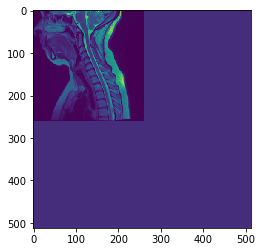

In [37]:
plt.imshow(a[0][0][:,:,0])

In [38]:
a[3][0]

[[110, 29, 26, 50],
 [124, 36, 26, 49],
 [111, 52, 26, 1],
 [119, 82, 26, 3],
 [124, 95, 26, 4],
 [130, 109, 26, 5],
 [136, 123, 26, 6],
 [142, 137, 26, 7],
 [149, 153, 26, 8],
 [156, 169, 26, 9],
 [163, 188, 26, 10],
 [169, 208, 26, 11],
 [174, 229, 26, 12],
 [176, 250, 26, 13]]

In [104]:
train_model_fcn_vl(a, 7, 7)

===== DETECTED 107 images that contains label no. 14 =====
Extracting patches
====DEBUG====
(1703, 20, 30, 1)
(1703, 20, 30, 1)
====DEBUG====


/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/ipykernel_launcher.py:108: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Data Augmentation: In progress
Data Augmentation: Done
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 3232        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 3 3232        input_1[0][0]                    
______________________________________________________

/home/GRAMES.POLYMTL.CA/luroub/anaconda3/envs/conda-37/lib/python3.7/site-packages/ipykernel_launcher.py:203: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<zip objec..., steps_per_epoch=170, epochs=1500, verbose=1, callbacks=[<keras.ca..., max_queue_size=10)`


Epoch 1/1500
170/170 [==============================] - 4s 25ms/step - loss: 557.0005

Epoch 00001: loss improved from inf to 557.00054, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Saving images heatmap (heatMap_epoch_0.png)
Epoch 2/1500
170/170 [==============================] - 3s 15ms/step - loss: 529.3930

Epoch 00002: loss improved from 557.00054 to 530.90551, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 3/1500
170/170 [==============================] - 3s 16ms/step - loss: 498.3758

Epoch 00003: loss improved from 530.90551 to 499.78770, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 4/1500
170/170 [==============================] - 3s 16ms/step - loss: 459.6348

Epoch 00004: loss improved from 499.78770 to 460.86818, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 5/1500
170/170 [==============================] - 3s 16ms/step - loss: 416.8807

Epoch 00005: loss improved from 460.86818 to 417.93913, saving model to ./fcn_VL_IVD_13_weights.best.hd

170/170 [==============================] - 3s 16ms/step - loss: 91.4112

Epoch 00043: loss improved from 94.89044 to 91.71592, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 44/1500
170/170 [==============================] - 3s 16ms/step - loss: 89.7546

Epoch 00044: loss improved from 91.71592 to 90.01356, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 45/1500
170/170 [==============================] - 3s 15ms/step - loss: 88.5226

Epoch 00045: loss improved from 90.01356 to 88.74808, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 46/1500
170/170 [==============================] - 3s 16ms/step - loss: 88.2331

Epoch 00046: loss improved from 88.74808 to 88.47647, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 47/1500
170/170 [==============================] - 3s 16ms/step - loss: 85.1157

Epoch 00047: loss improved from 88.47647 to 85.37123, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 48/1500
170/170 [==============================] - 3s

Epoch 91/1500
170/170 [==============================] - 3s 16ms/step - loss: 57.1339

Epoch 00091: loss did not improve from 56.06721
Saving images heatmap (heatMap_epoch_90.png)
Epoch 92/1500
170/170 [==============================] - 3s 16ms/step - loss: 55.2032

Epoch 00092: loss improved from 56.06721 to 55.23935, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 93/1500
170/170 [==============================] - 3s 16ms/step - loss: 57.6209

Epoch 00093: loss did not improve from 55.23935
Epoch 94/1500
170/170 [==============================] - 3s 17ms/step - loss: 54.7318

Epoch 00094: loss improved from 55.23935 to 54.89567, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 95/1500
170/170 [==============================] - 3s 16ms/step - loss: 55.7492

Epoch 00095: loss did not improve from 54.89567
Epoch 96/1500
170/170 [==============================] - 3s 16ms/step - loss: 54.3124

Epoch 00096: loss improved from 54.89567 to 54.40609, saving model to ./fcn_VL_IV

Epoch 143/1500
170/170 [==============================] - 3s 15ms/step - loss: 44.8333

Epoch 00143: loss did not improve from 44.19289
Epoch 144/1500
170/170 [==============================] - 3s 16ms/step - loss: 45.0106

Epoch 00144: loss did not improve from 44.19289
Epoch 145/1500
170/170 [==============================] - 3s 15ms/step - loss: 44.6087

Epoch 00145: loss did not improve from 44.19289
Epoch 146/1500
170/170 [==============================] - 3s 15ms/step - loss: 44.3894

Epoch 00146: loss did not improve from 44.19289
Epoch 147/1500
170/170 [==============================] - 2s 14ms/step - loss: 44.9269

Epoch 00147: loss did not improve from 44.19289
Epoch 148/1500
170/170 [==============================] - 2s 14ms/step - loss: 44.8150

Epoch 00148: loss did not improve from 44.19289
Epoch 149/1500
170/170 [==============================] - 2s 14ms/step - loss: 45.3673

Epoch 00149: loss did not improve from 44.19289
Epoch 150/1500
170/170 [========================


Epoch 00196: loss did not improve from 38.42995
Epoch 197/1500
170/170 [==============================] - 3s 16ms/step - loss: 39.1947

Epoch 00197: loss did not improve from 38.42995
Epoch 198/1500
170/170 [==============================] - 3s 16ms/step - loss: 39.5524

Epoch 00198: loss did not improve from 38.42995
Epoch 199/1500
170/170 [==============================] - 3s 16ms/step - loss: 39.1757

Epoch 00199: loss did not improve from 38.42995
Epoch 200/1500
170/170 [==============================] - 3s 17ms/step - loss: 39.0556

Epoch 00200: loss did not improve from 38.42995
Epoch 201/1500
170/170 [==============================] - 3s 16ms/step - loss: 39.7413

Epoch 00201: loss did not improve from 38.42995
Saving images heatmap (heatMap_epoch_200.png)
Epoch 202/1500
170/170 [==============================] - 2s 14ms/step - loss: 37.9960

Epoch 00202: loss improved from 38.42995 to 38.11507, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 203/1500
170/170 [=========

170/170 [==============================] - 3s 15ms/step - loss: 34.1170

Epoch 00251: loss did not improve from 34.03982
Saving images heatmap (heatMap_epoch_250.png)
Epoch 252/1500
170/170 [==============================] - 2s 14ms/step - loss: 35.2733

Epoch 00252: loss did not improve from 34.03982
Epoch 253/1500
170/170 [==============================] - 2s 14ms/step - loss: 33.2791

Epoch 00253: loss improved from 34.03982 to 33.36710, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 254/1500
170/170 [==============================] - 3s 15ms/step - loss: 34.0902

Epoch 00254: loss did not improve from 33.36710
Epoch 255/1500
170/170 [==============================] - 3s 15ms/step - loss: 34.6043

Epoch 00255: loss did not improve from 33.36710
Epoch 256/1500
170/170 [==============================] - 3s 16ms/step - loss: 34.2327

Epoch 00256: loss did not improve from 33.36710
Epoch 257/1500
170/170 [==============================] - 3s 16ms/step - loss: 34.4743

Epoch 002

170/170 [==============================] - 2s 14ms/step - loss: 29.8993

Epoch 00307: loss improved from 30.87915 to 29.96064, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 308/1500
170/170 [==============================] - 2s 14ms/step - loss: 30.4845

Epoch 00308: loss did not improve from 29.96064
Epoch 309/1500
170/170 [==============================] - 2s 14ms/step - loss: 31.0550

Epoch 00309: loss did not improve from 29.96064
Epoch 310/1500
170/170 [==============================] - 2s 15ms/step - loss: 30.7424

Epoch 00310: loss did not improve from 29.96064
Epoch 311/1500
170/170 [==============================] - 2s 15ms/step - loss: 30.2267

Epoch 00311: loss did not improve from 29.96064
Saving images heatmap (heatMap_epoch_310.png)
Epoch 312/1500
170/170 [==============================] - 2s 13ms/step - loss: 30.8975

Epoch 00312: loss did not improve from 29.96064
Epoch 313/1500
170/170 [==============================] - 2s 14ms/step - loss: 31.5814

Epoch 003

170/170 [==============================] - 2s 14ms/step - loss: 27.4217

Epoch 00362: loss improved from 27.57471 to 27.50064, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 363/1500
170/170 [==============================] - 3s 16ms/step - loss: 28.4800

Epoch 00363: loss did not improve from 27.50064
Epoch 364/1500
170/170 [==============================] - 3s 16ms/step - loss: 28.8725

Epoch 00364: loss did not improve from 27.50064
Epoch 365/1500
170/170 [==============================] - 3s 16ms/step - loss: 27.7516

Epoch 00365: loss did not improve from 27.50064
Epoch 366/1500
170/170 [==============================] - 3s 17ms/step - loss: 28.2436

Epoch 00366: loss did not improve from 27.50064
Epoch 367/1500
170/170 [==============================] - 3s 16ms/step - loss: 28.9791

Epoch 00367: loss did not improve from 27.50064
Epoch 368/1500
170/170 [==============================] - 3s 15ms/step - loss: 28.3466

Epoch 00368: loss did not improve from 27.50064
Epoch 3

170/170 [==============================] - 3s 15ms/step - loss: 25.7712

Epoch 00417: loss did not improve from 24.97881
Epoch 418/1500
170/170 [==============================] - 3s 15ms/step - loss: 25.2665

Epoch 00418: loss did not improve from 24.97881
Epoch 419/1500
170/170 [==============================] - 3s 15ms/step - loss: 25.4132

Epoch 00419: loss did not improve from 24.97881
Epoch 420/1500
170/170 [==============================] - 3s 15ms/step - loss: 24.8104

Epoch 00420: loss improved from 24.97881 to 24.89990, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 421/1500
170/170 [==============================] - 3s 15ms/step - loss: 24.9908

Epoch 00421: loss did not improve from 24.89990
Saving images heatmap (heatMap_epoch_420.png)
Epoch 422/1500
170/170 [==============================] - 2s 13ms/step - loss: 26.0116

Epoch 00422: loss did not improve from 24.89990
Epoch 423/1500
170/170 [==============================] - 2s 13ms/step - loss: 26.2835

Epoch 004

170/170 [==============================] - 3s 16ms/step - loss: 23.7925

Epoch 00473: loss did not improve from 23.61305
Epoch 474/1500
170/170 [==============================] - 3s 15ms/step - loss: 23.1854

Epoch 00474: loss improved from 23.61305 to 23.27295, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 475/1500
170/170 [==============================] - 2s 14ms/step - loss: 23.7228

Epoch 00475: loss did not improve from 23.27295
Epoch 476/1500
170/170 [==============================] - 3s 16ms/step - loss: 22.9604

Epoch 00476: loss improved from 23.27295 to 23.02004, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 477/1500
170/170 [==============================] - 3s 15ms/step - loss: 23.8500

Epoch 00477: loss did not improve from 23.02004
Epoch 478/1500
170/170 [==============================] - 3s 16ms/step - loss: 24.3598

Epoch 00478: loss did not improve from 23.02004
Epoch 479/1500
170/170 [==============================] - 3s 15ms/step - loss: 22.9903


170/170 [==============================] - 2s 14ms/step - loss: 22.2121

Epoch 00528: loss did not improve from 21.85628
Epoch 529/1500
170/170 [==============================] - 2s 14ms/step - loss: 22.8546

Epoch 00529: loss did not improve from 21.85628
Epoch 530/1500
170/170 [==============================] - 2s 13ms/step - loss: 22.0478

Epoch 00530: loss did not improve from 21.85628
Epoch 531/1500
170/170 [==============================] - 2s 13ms/step - loss: 22.2610

Epoch 00531: loss did not improve from 21.85628
Saving images heatmap (heatMap_epoch_530.png)
Epoch 532/1500
170/170 [==============================] - 2s 14ms/step - loss: 22.3503

Epoch 00532: loss did not improve from 21.85628
Epoch 533/1500
170/170 [==============================] - 3s 15ms/step - loss: 21.5949

Epoch 00533: loss improved from 21.85628 to 21.64353, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 534/1500
170/170 [==============================] - 3s 16ms/step - loss: 22.2028

Epoch 005

170/170 [==============================] - 3s 15ms/step - loss: 21.5086

Epoch 00583: loss did not improve from 20.10277
Epoch 584/1500
170/170 [==============================] - 3s 16ms/step - loss: 22.0172

Epoch 00584: loss did not improve from 20.10277
Epoch 585/1500
170/170 [==============================] - 3s 17ms/step - loss: 21.1817

Epoch 00585: loss did not improve from 20.10277
Epoch 586/1500
170/170 [==============================] - 3s 16ms/step - loss: 20.9173

Epoch 00586: loss did not improve from 20.10277
Epoch 587/1500
170/170 [==============================] - 3s 16ms/step - loss: 20.8315

Epoch 00587: loss did not improve from 20.10277
Epoch 588/1500
170/170 [==============================] - 3s 16ms/step - loss: 20.9387

Epoch 00588: loss did not improve from 20.10277
Epoch 589/1500
170/170 [==============================] - 3s 16ms/step - loss: 20.6976

Epoch 00589: loss did not improve from 20.10277
Epoch 590/1500
170/170 [==============================] - 3s 15

170/170 [==============================] - 3s 16ms/step - loss: 19.6760

Epoch 00641: loss did not improve from 19.20435
Saving images heatmap (heatMap_epoch_640.png)
Epoch 642/1500
170/170 [==============================] - 2s 14ms/step - loss: 19.9850

Epoch 00642: loss did not improve from 19.20435
Epoch 643/1500
170/170 [==============================] - 3s 15ms/step - loss: 19.5510

Epoch 00643: loss did not improve from 19.20435
Epoch 644/1500
170/170 [==============================] - 3s 17ms/step - loss: 20.1022

Epoch 00644: loss did not improve from 19.20435
Epoch 645/1500
170/170 [==============================] - 3s 16ms/step - loss: 19.8763

Epoch 00645: loss did not improve from 19.20435
Epoch 646/1500
170/170 [==============================] - 3s 16ms/step - loss: 19.9286

Epoch 00646: loss did not improve from 19.20435
Epoch 647/1500
170/170 [==============================] - 3s 16ms/step - loss: 20.1385

Epoch 00647: loss did not improve from 19.20435
Epoch 648/1500
17

170/170 [==============================] - 3s 16ms/step - loss: 18.4898

Epoch 00698: loss improved from 18.71605 to 18.55424, saving model to ./fcn_VL_IVD_13_weights.best.hdf5
Epoch 699/1500
170/170 [==============================] - 3s 16ms/step - loss: 19.2740

Epoch 00699: loss did not improve from 18.55424
Epoch 700/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.9756

Epoch 00700: loss did not improve from 18.55424
Epoch 701/1500
170/170 [==============================] - 3s 15ms/step - loss: 19.2623

Epoch 00701: loss did not improve from 18.55424
Saving images heatmap (heatMap_epoch_700.png)
Epoch 702/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.7836

Epoch 00702: loss did not improve from 18.55424
Epoch 703/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.9081

Epoch 00703: loss did not improve from 18.55424
Epoch 704/1500
170/170 [==============================] - 3s 16ms/step - loss: 18.9433

Epoch 007

170/170 [==============================] - 2s 14ms/step - loss: 18.4718

Epoch 00754: loss did not improve from 17.27860
Epoch 755/1500
170/170 [==============================] - 2s 15ms/step - loss: 18.0629

Epoch 00755: loss did not improve from 17.27860
Epoch 756/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.3412

Epoch 00756: loss did not improve from 17.27860
Epoch 757/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.6223

Epoch 00757: loss did not improve from 17.27860
Epoch 758/1500
170/170 [==============================] - 3s 15ms/step - loss: 17.2896

Epoch 00758: loss did not improve from 17.27860
Epoch 759/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.8646

Epoch 00759: loss did not improve from 17.27860
Epoch 760/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.0643

Epoch 00760: loss did not improve from 17.27860
Epoch 761/1500
170/170 [==============================] - 3s 15

Epoch 812/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.4279

Epoch 00812: loss did not improve from 17.27860
Epoch 813/1500
170/170 [==============================] - 3s 16ms/step - loss: 18.2712

Epoch 00813: ReduceLROnPlateau reducing learning rate to 3.1249999921101335e-08.

Epoch 00813: loss did not improve from 17.27860
Epoch 814/1500
170/170 [==============================] - 3s 16ms/step - loss: 18.6540

Epoch 00814: loss did not improve from 17.27860
Epoch 815/1500
170/170 [==============================] - 3s 16ms/step - loss: 18.6529

Epoch 00815: loss did not improve from 17.27860
Epoch 816/1500
170/170 [==============================] - 3s 16ms/step - loss: 17.4578

Epoch 00816: loss did not improve from 17.27860
Epoch 817/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.4916

Epoch 00817: loss did not improve from 17.27860
Epoch 818/1500
170/170 [==============================] - 3s 15ms/step - loss: 17.3409

Epoch 00818: l

170/170 [==============================] - 3s 16ms/step - loss: 18.9014

Epoch 00869: loss did not improve from 17.27860
Epoch 870/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.6656

Epoch 00870: loss did not improve from 17.27860
Epoch 871/1500
170/170 [==============================] - 3s 15ms/step - loss: 17.9052

Epoch 00871: loss did not improve from 17.27860
Saving images heatmap (heatMap_epoch_870.png)
Epoch 872/1500
170/170 [==============================] - 2s 13ms/step - loss: 18.0829

Epoch 00872: loss did not improve from 17.27860
Epoch 873/1500
170/170 [==============================] - 2s 14ms/step - loss: 18.7703

Epoch 00873: ReduceLROnPlateau reducing learning rate to 7.812499980275334e-09.

Epoch 00873: loss did not improve from 17.27860
Epoch 874/1500
170/170 [==============================] - 3s 16ms/step - loss: 17.6889

Epoch 00874: loss did not improve from 17.27860
Epoch 875/1500
170/170 [==============================] - 3s 16ms/step -

170/170 [==============================] - 3s 16ms/step - loss: 17.5724

Epoch 00925: loss did not improve from 16.91086
Epoch 926/1500
170/170 [==============================] - 3s 16ms/step - loss: 17.3176

Epoch 00926: loss did not improve from 16.91086
Epoch 927/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.8343

Epoch 00927: loss did not improve from 16.91086
Epoch 928/1500
170/170 [==============================] - 2s 13ms/step - loss: 17.8021

Epoch 00928: loss did not improve from 16.91086
Epoch 929/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.5934

Epoch 00929: loss did not improve from 16.91086
Epoch 930/1500
170/170 [==============================] - 3s 16ms/step - loss: 17.8030

Epoch 00930: loss did not improve from 16.91086
Epoch 931/1500
170/170 [==============================] - 3s 16ms/step - loss: 19.1614

Epoch 00931: loss did not improve from 16.91086
Saving images heatmap (heatMap_epoch_930.png)
Epoch 932/1500
17

170/170 [==============================] - 2s 13ms/step - loss: 18.3269

Epoch 00982: loss did not improve from 16.91086
Epoch 983/1500
170/170 [==============================] - 2s 14ms/step - loss: 18.1874

Epoch 00983: loss did not improve from 16.91086
Epoch 984/1500
170/170 [==============================] - 3s 16ms/step - loss: 17.9269

Epoch 00984: loss did not improve from 16.91086
Epoch 985/1500
170/170 [==============================] - 3s 16ms/step - loss: 18.6365

Epoch 00985: loss did not improve from 16.91086
Epoch 986/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.4122

Epoch 00986: loss did not improve from 16.91086
Epoch 987/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.0414

Epoch 00987: loss did not improve from 16.91086
Epoch 988/1500
170/170 [==============================] - 3s 15ms/step - loss: 18.5771

Epoch 00988: loss did not improve from 16.91086
Epoch 989/1500
170/170 [==============================] - 3s 15

KeyboardInterrupt: 

In [59]:
def caffe_eucl_loss(x, y):
    return K.sum(K.square(x - y)) / 2

class Generate_Big_HeatMap(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        if epoch%10 == 0:
            global testing_image
            #print("=========================== DEBUG ==============================")
            #print(testing_image.shape)
            img = np.expand_dims(testing_image, axis=0)
            prediction = self.model.predict(img, verbose=0)
            save_HeatMap(prediction[0,:,:,0], name_img = 'heatMap_epoch_' + str(epoch) + '.png')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

def save_HeatMap(heatMap, name_img = "heatmap.png"):
    """
    Save heatMap

    :param Image_list:
    :return:
    """

    print("Saving images heatmap (" + name_img + ")")

    ## TODO: Use matplotlib for this
    import cv2
    image_cm = cv2.applyColorMap(np.array(heatMap * 255, dtype=np.uint8), cv2.COLORMAP_JET)
    img_out = array_to_img(image_cm)#, data_format='channels_first')
    img_out.save('./storage' + name_img )

In [41]:
def patch_testing(DataSet, start_lb, end_lb, train = True, test = False):
   

    [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label] = DataSet

    global testing_image
    testing_image = val_ds_img[0]

    epochs = 30
    batch_size = 10

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = []
    tmp_train_img = []
    label_number = 14

    for lbs in range(len(train_ds_label)):
         if get_x_label_coordenates_exist(train_ds_label[lbs], label_number):
                tmp_train_img.append(train_ds_img[lbs])
                tmp_train_labels.append(train_ds_label[lbs])

    train_ds_img = np.array(tmp_train_img)
    train_ds_label = tmp_train_labels
    print("===== DETECTED " + str(train_ds_img.shape[0]) + " images that contains label no. " + str(label_number) + " =====")

    # Now make the trining datases using only the subset with that contain the "label_number" label
    print("Extracting patches")
    tmp_train_patch = []
    tmp_train_mask_patch = []
    for lbn in range(4, label_number):
    #for lbn in [label_number-1]:
    #for lbn in [3,label_number]:
        train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,lbn)
        train_lbs_tmp = np.array(train_lbs_tmp)

        train_lbs_tmp_mask = label2MaskMap(train_lbs_tmp, radius = 20, normalize = True)

        for i in range(train_ds_img.shape[0]):

            train_patch = []
            train_mask_patch = []
            train_patch_negative = []
            train_mask_patch_negative = []

            # Make patch
            dx = 15
            dy = 10

            x = train_lbs_tmp[i,0]
            y = train_lbs_tmp[i,1]
            org_shape =  train_ds_img[i, y - dy : y + dy, x - dx : x + dx, 0].shape
            if org_shape == (2 * dy,2 * dx):
                train_patch.append(train_ds_img[i, y - dy : y + dy, x - dx : x + dx, 0])
                train_mask_patch.append(train_lbs_tmp_mask[i, y - dy : y + dy, x - dx : x + dx])

            # generate negative patch for training
            import random
            random_num = random.randint(0,1)
            if random_num == 0: # left side of IVD selected randomly
                xr = random.randint(dx + 1, x - dx - 10)
                org_shape =  train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0].shape
                if org_shape == (2 * dy,2 * dx):
                    train_patch_negative.append(train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0])
                    train_mask_patch_negative.append(train_lbs_tmp_mask[i, y - dy : y + dy, xr - dx : xr + dx])
            else: # right side of IVD selected randomly
                xr = random.randint(x + dx + 10, x + dx + 30)
                org_shape =  train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0].shape
                if org_shape == (2 * dy,2 * dx):
                    train_patch_negative.append(train_ds_img[i, y - dy : y + dy, xr - dx : xr + dx, 0])
                    train_mask_patch_negative.append(train_lbs_tmp_mask[i, y - dy : y + dy, xr - dx : xr + dx])

            # add negative patch to the traiig list
            random_num = random.randint(0,100)
            if random_num < 60: #If do not work go to 50 ;)
                train_patch.extend(train_patch_negative)
                train_mask_patch.extend(train_mask_patch_negative)

            # getting the patch for all IVD
            tmp_train_patch.extend(train_patch)
            tmp_train_mask_patch.extend(train_mask_patch)


    train_patch = np.array(tmp_train_patch)
    train_mask_patch = np.array(tmp_train_mask_patch)
    train_patch = np.expand_dims(train_patch, axis=3)
    train_mask_patch = np.expand_dims(train_mask_patch, axis=3)
    return [train_patch,train_mask_patch,train_lbs_tmp_mask]

In [42]:
b=patch_testing(a,7,7)

===== DETECTED 107 images that contains label no. 14 =====
Extracting patches


In [43]:
b[0].shape

(1712, 20, 30, 1)

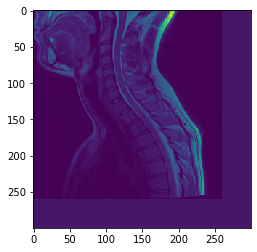

In [49]:
plt.imshow(test_gt[1][0,:300,:300,0])

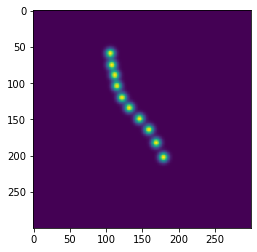

In [50]:
plt.imshow(test_gt[0][0,:300,:300])

In [ ]:
189/170

In [ ]:
def denormalize2uint8(img):
    img = img  - np.amin(img)
    img = img * 255.0/np.amax(img)
    img = np.array(img, dtype=np.uint8)
    return img

def deploy_model_fcn_vl(DataSet, val=True, test=True):
    #print("Deploy and calculate L2 metric")
    #time.sleep(5)
    [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label] = DataSet

    loss_predictions_val = []
    loss_predictions_test = []

    #val_lbs_tmp = vlds.get_x_label_coordenates_list(val_ds_label, lbn)
    #val_lbs_tmp = np.array(val_lbs_tmp)

    #test_lbs_tmp = vlds.get_x_label_coordenates_list(test_ds_label, lbn)
    #test_lbs_tmp = np.array(test_lbs_tmp)

    batch_size = 1

    # ==================
    # LOAD THE DL MODEL
    # ==================
    model = fcn_vl_v1()

    model.summary()

    model_filepath = "./fcn_VL_IVD_13_weights.best.hdf5"


    # load weights
    model.load_weights(model_filepath)

    if val:

        loss_predictions = []
        for i in range(val_ds_img.shape[0]):
            # Save image
            img_out = array_to_img(val_ds_img[i, :,:,:])#, data_format='channels_first')
            img_out.save('fcn_VL/' + '_val_' + '%04d' % i + '_anat.png')

            # Apply the preprocessing
            img = val_ds_img[i, :,:,0]
            img = denormalize2uint8(img)
            img = preprocessing_before_inference(img)
            img = normalize(img)

            # Generate and save prediction
            img = np.expand_dims(img, axis=2)
            img = np.expand_dims(img, axis=0)
            prediction = model.predict(img, verbose=0)

            # Save prediction to PNG
            pred_out = array_to_img(prediction[0,:,:,:])#, data_format='channels_first')
            pred_out.save('fcn_VL/' + '_val_' + '%04d' % i + '_pred.png')

            save_HeatMap(prediction[0,:,:,0], name_img = 'fcn_VL/' + '_val_' + '%04d' % i + '_heatMap.png')

            save_detections(val_ds_img[i, :,:,0], prediction[0,:,:,0], 'fcn_VL/' + '_val_' + '%04d' % i + '_det.png')

            # generate Overlap images
            #img_pred = array_to_img(prediction[i, :,:,:])
            img_anat = denormalize2uint8(val_ds_img[i, :,:,0])
            img_anat = np.dstack((img_anat,img_anat,img_anat))
            img_pred = denormalize2uint8(prediction[0, :,:,0])
            img_pred =  cv2.applyColorMap(img_pred, cv2.COLORMAP_JET)
            added_image = cv2.addWeighted(img_anat,1.0,img_pred,0.2,0)
            cv2.imwrite('fcn_VL/' + '_val_' + '%04d' % i + '_combined.png', added_image)


    if test:
        predictions_test = model.predict(test_ds_img, batch_size=batch_size, verbose=0)

        loss_predictions = []
        for i in range(test_ds_img.shape[0]):
            # Save image
            img_out = array_to_img(test_ds_img[i, :,:,:])#, data_format='channels_first')
            img_out.save('fcn_VL/' + '_test_' + '%04d' % i + '_anat.png')

            # Apply the preprocessing
            img = test_ds_img[i, :,:,0]
            img = denormalize2uint8(img)
            img = preprocessing_before_inference(img)
            img = normalize(img)

            # Generate and save prediction
            img = np.expand_dims(img, axis=2)
            img = np.expand_dims(img, axis=0)
            prediction = model.predict(img, verbose=0)

            # Save prediction to PNG
            pred_out = array_to_img(prediction[0,:,:,:])#, data_format='channels_first')
            pred_out.save('fcn_VL/' + '_test_' + '%04d' % i + '_pred.png')

            save_HeatMap(prediction[0,:,:,0], name_img = 'fcn_VL/' + '_test_' + '%04d' % i + '_heatMap.png')

            save_detections(test_ds_img[i, :,:,0], prediction[0,:,:,0], 'fcn_VL/' + '_test_' + '%04d' % i + '_det.png')

            # generate Overlap images
            #img_pred = array_to_img(prediction[i, :,:,:])
            img_anat = denormalize2uint8(test_ds_img[i, :,:,0])
            img_anat = np.dstack((img_anat,img_anat,img_anat))
            img_pred = denormalize2uint8(prediction[0, :,:,0])
            img_pred =  cv2.applyColorMap(img_pred, cv2.COLORMAP_JET)
            added_image = cv2.addWeighted(img_anat,1.0,img_pred,0.2,0)
            cv2.imwrite('fcn_VL/' + '_test_' + '%04d' % i + '_combined.png', added_image)


    K.clear_session()



In [98]:
res_t=model.predict(a[1][1][:300,:300])

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (300, 300, 1)

In [91]:
model = fcn_vl_v3()

model.summary()

model_filepath = "./fcn_VL_IVD_13_weights.best.hdf5"


        # load weights
model.load_weights(model_filepath)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 64          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 3 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (

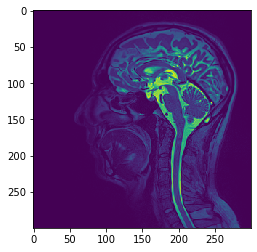

In [99]:
plt.imshow(a[1][1][:300,:300,0])

In [47]:
def extract_groundtruth(DataSet, start_lb, end_lb, train = True, test = False):
    
   

    [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label] = DataSet

    global testing_image
    testing_image = val_ds_img[0]

    epochs = 30
    batch_size = 10

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = []
    tmp_train_img = []
    label_number = 14

    for lbs in range(len(train_ds_label)):
         if get_x_label_coordenates_exist(train_ds_label[lbs], label_number):
                tmp_train_img.append(train_ds_img[lbs])
                tmp_train_labels.append(train_ds_label[lbs])

    train_ds_img = np.array(tmp_train_img)
    train_ds_label = tmp_train_labels
    print("===== DETECTED " + str(train_ds_img.shape[0]) + " images that contains label no. " + str(label_number) + " =====")
    train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,4)
    train_lbs_tmp = np.array(train_lbs_tmp)

    final= label2MaskMap(train_lbs_tmp, radius = 20, normalize = True)
        # Now make the trining datases using only the subset with that contain the "label_number" label
    for lbn in range(5, label_number):
        #for lbn in [label_number-1]:
        #for lbn in [3,label_number]:
        train_lbs_tmp = get_x_label_coordenates_list(train_ds_label,lbn)
        train_lbs_tmp = np.array(train_lbs_tmp)

        train_lbs_tmp_mask = label2MaskMap(train_lbs_tmp, radius = 20, normalize = True)
        final=np.add(final,train_lbs_tmp_mask)
    return [final,train_ds_img]

In [48]:
test_gt=extract_groundtruth(a,7,7)

===== DETECTED 107 images that contains label no. 14 =====


In [149]:
test_gt[0].shape

(107, 512, 512)

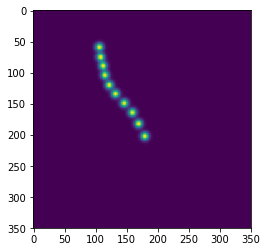

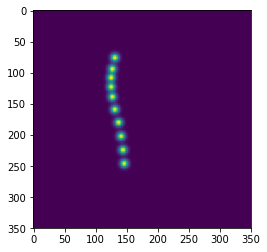

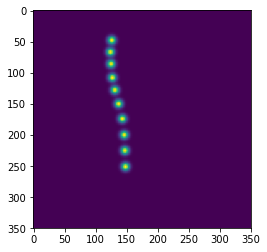

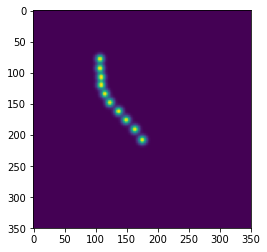

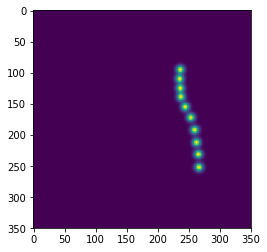

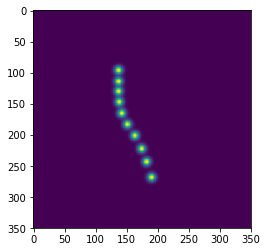

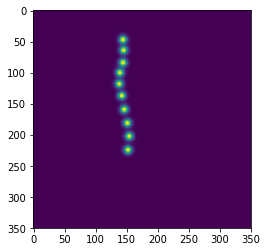

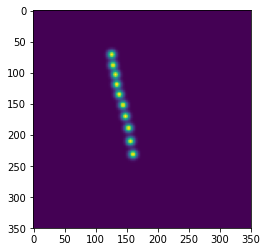

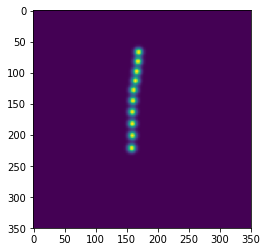

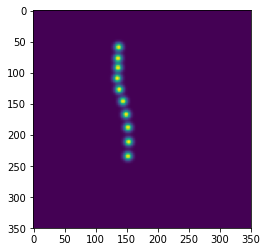

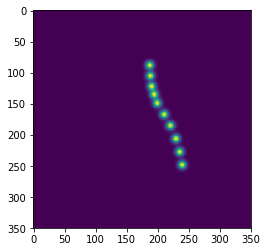

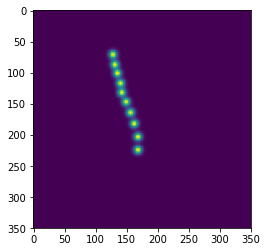

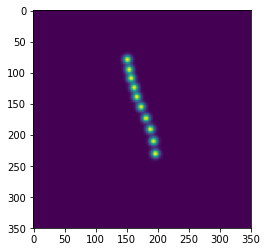

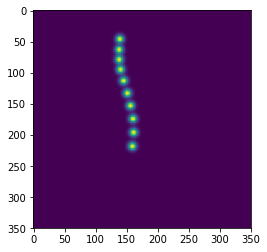

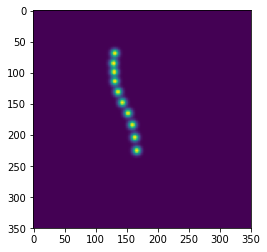

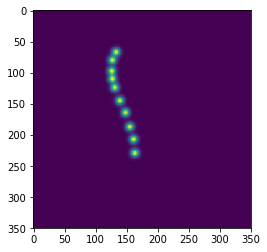

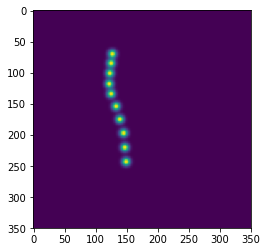

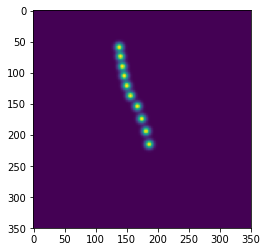

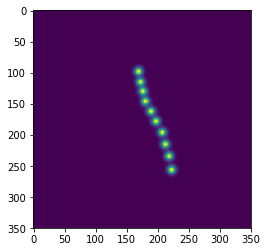

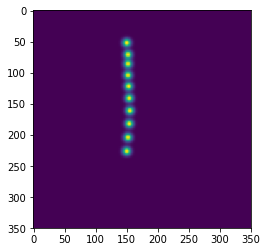

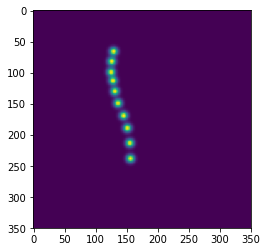

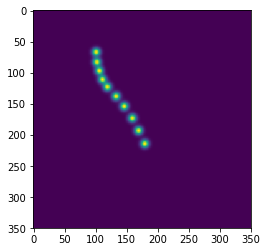

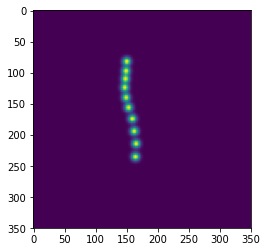

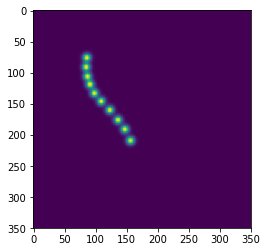

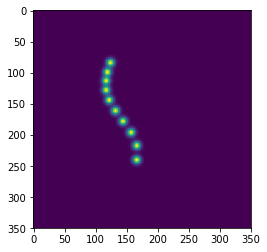

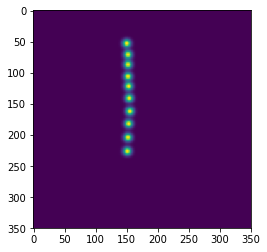

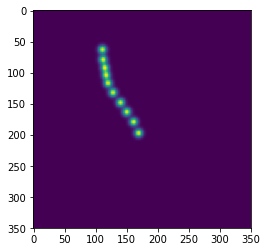

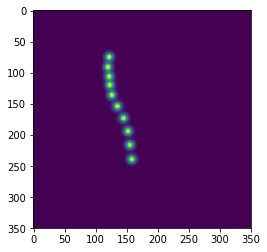

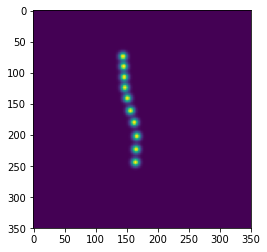

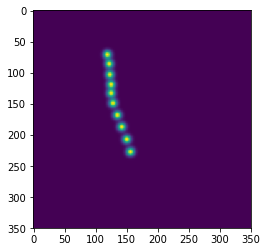

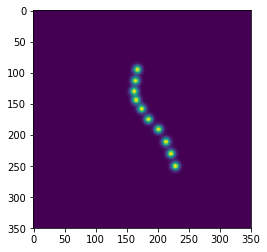

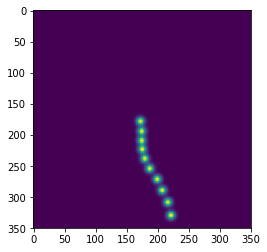

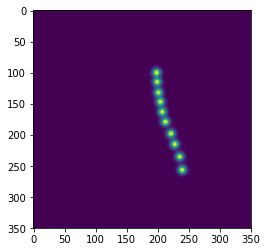

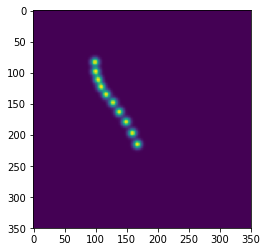

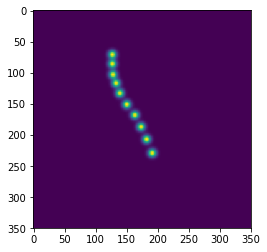

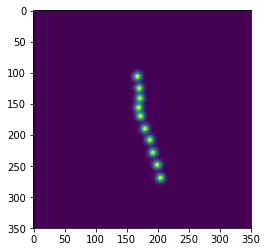

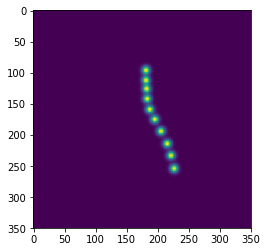

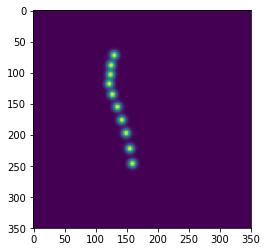

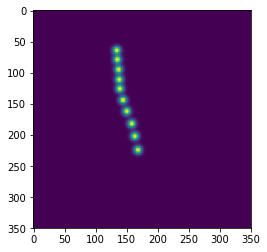

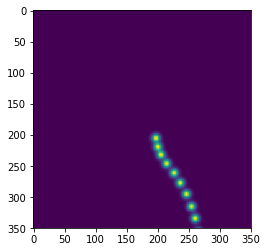

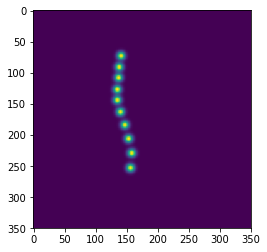

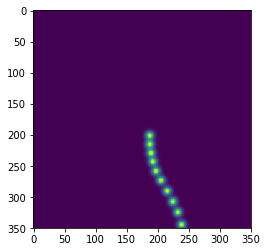

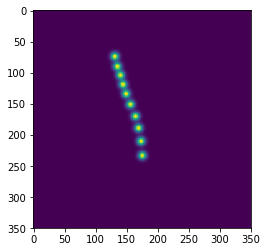

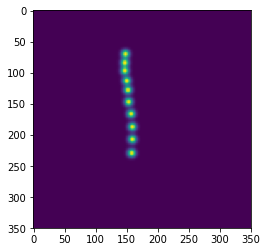

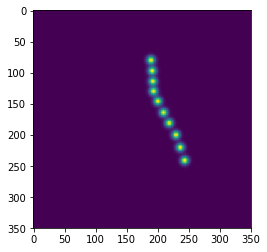

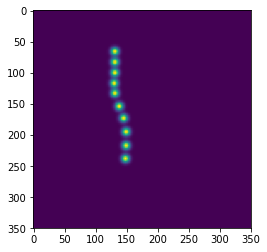

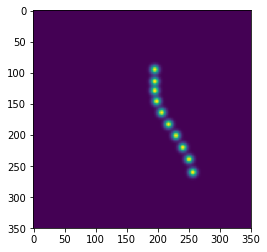

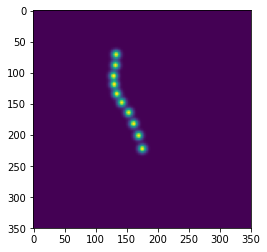

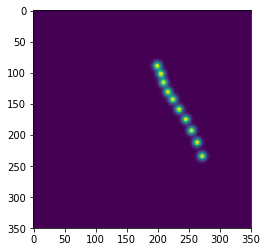

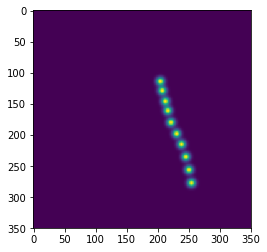

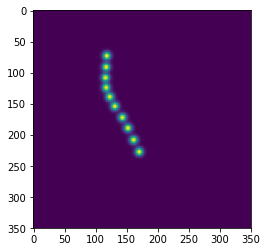

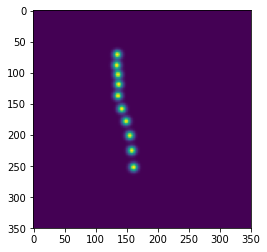

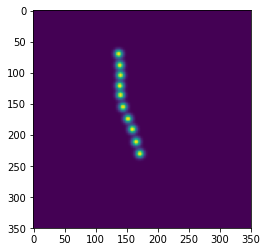

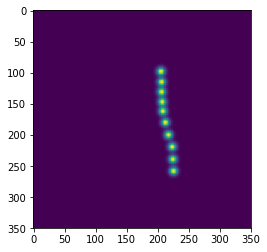

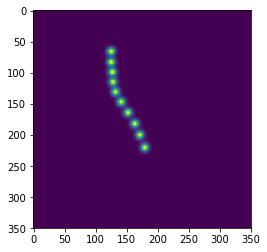

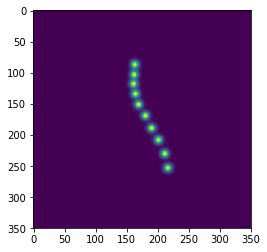

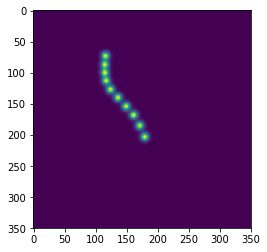

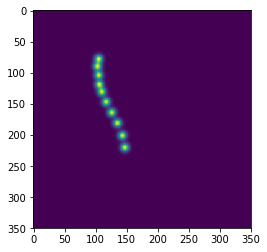

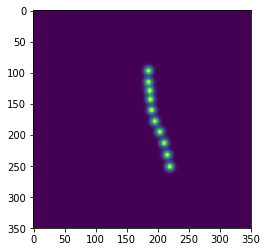

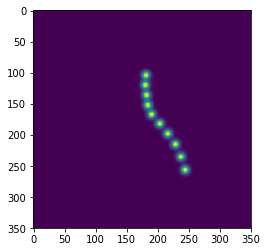

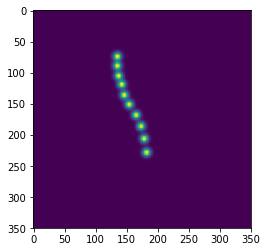

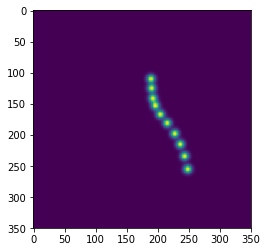

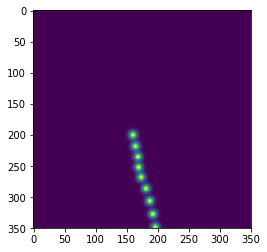

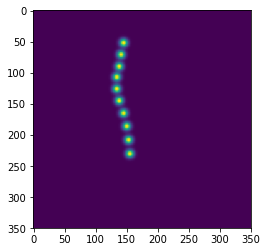

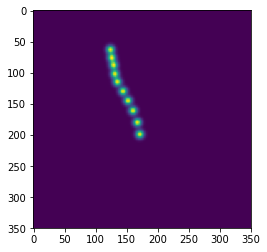

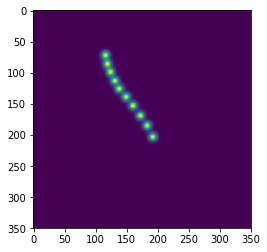

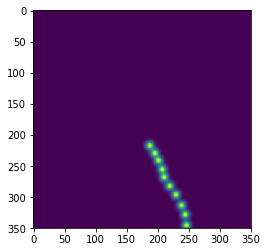

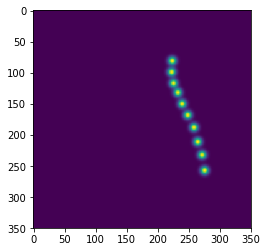

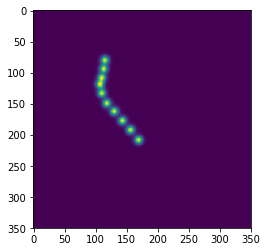

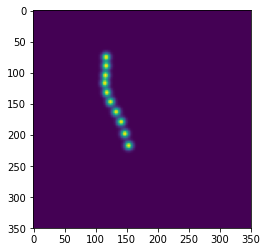

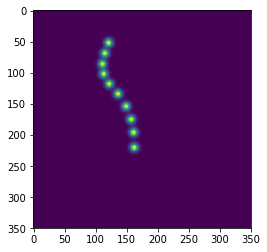

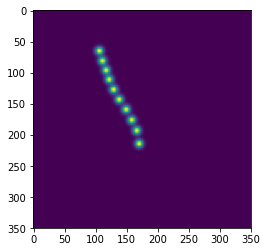

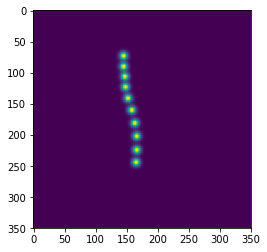

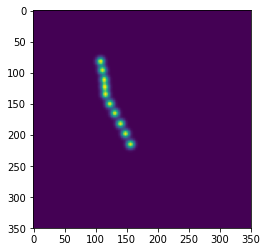

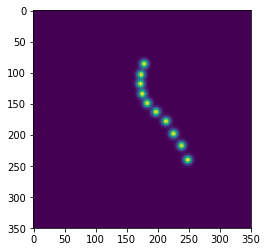

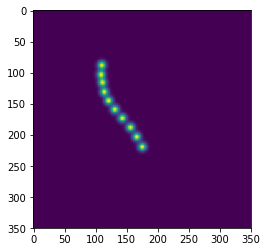

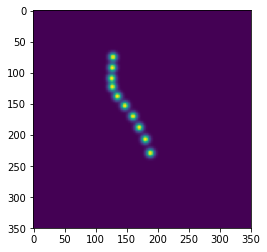

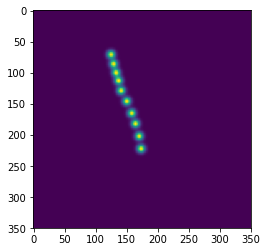

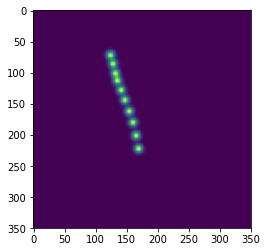

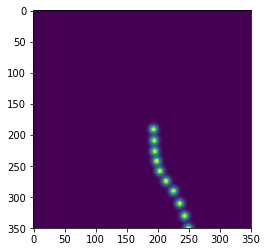

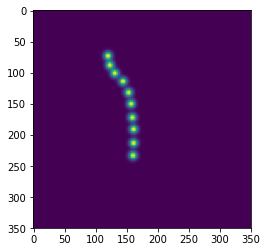

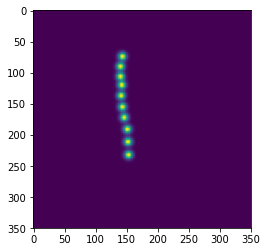

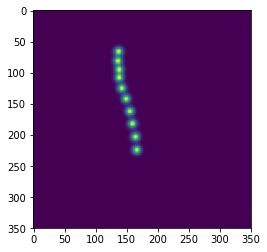

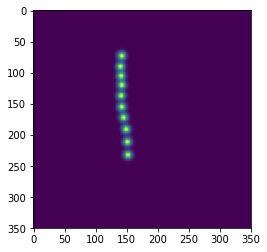

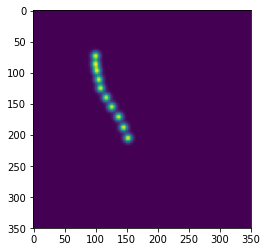

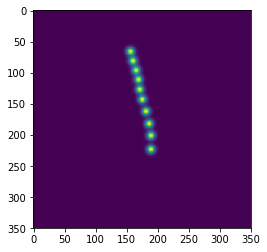

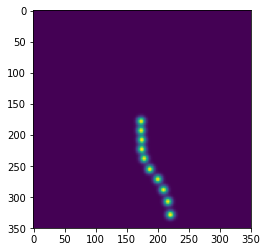

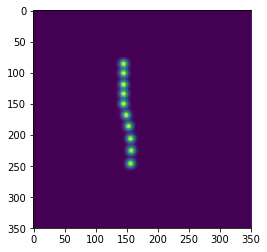

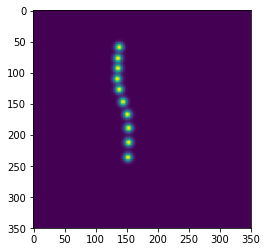

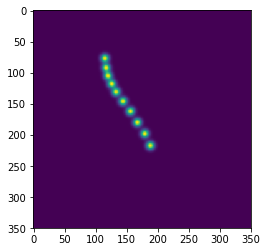

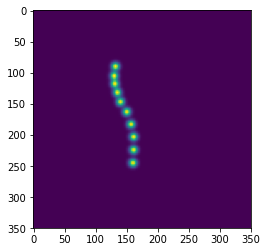

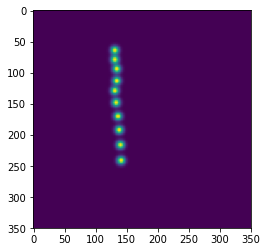

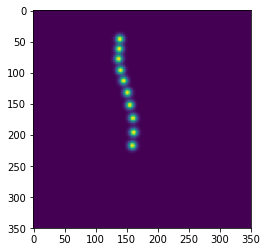

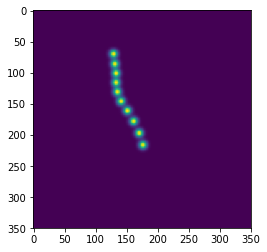

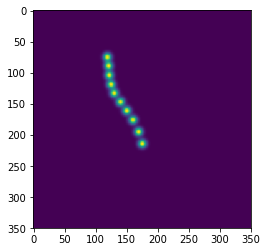

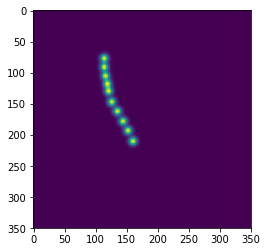

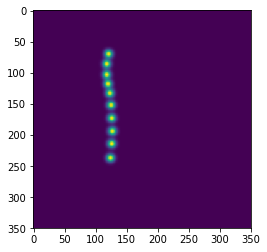

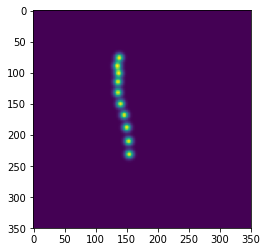

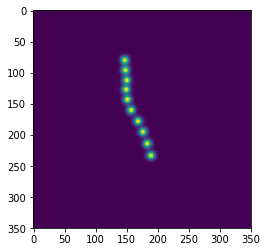

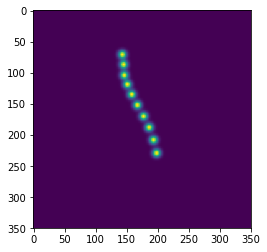

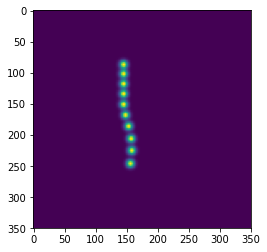

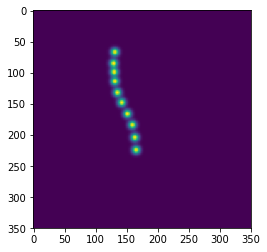

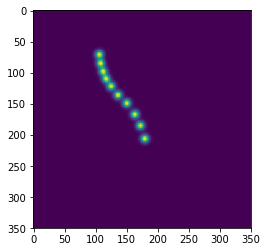

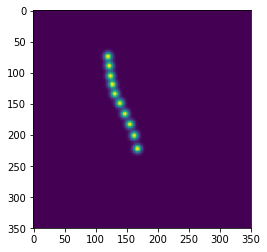

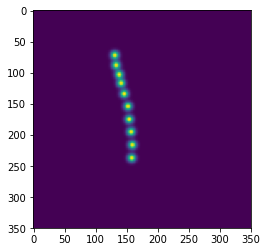

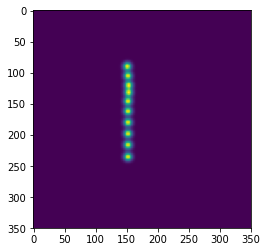

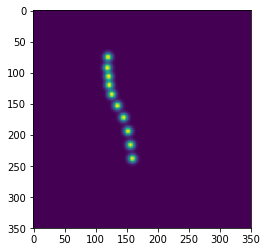

In [141]:
for i in range (107):
    plt.imshow(test_gt[i,:350,:350])
    plt.show()

In [100]:
def train_model_fcn_vl_lucas_v2(DataSet, start_lb, end_lb, train = True, test = False):

    [train_ds_img, val_ds_img, test_ds_img, train_ds_label, val_ds_label, test_ds_label] = DataSet

    global testing_image
    testing_image = val_ds_img[0]

    epochs = 1
    batch_size = 2

    # Selecting only the train images that contatins the end label
    # in these case 15 --> from C2-C3 to T7-T8 disc
    # remember that with these method big amount of training images will be descarted

    tmp_train_labels = []
    tmp_train_img = []
    label_number = 14

    final_data=extract_groundtruth(DataSet,7,7)
    train_patch=final_data[1]
    train_mask_patch = np.expand_dims(final_data[0], axis=3)
    #====DEBUG====
    print("====DEBUG====")
    print(train_patch.shape)
    print(train_mask_patch.shape)
    print("====DEBUG====")
    time.sleep(5)
    #====DEBUG====

    # Export groud truth
    import cv2
    image_cm = cv2.applyColorMap(np.array(train_mask_patch[0,:,:,0] * 255, dtype=np.uint8), cv2.COLORMAP_JET)
    img_out = array_to_img(image_cm)#, data_format='channels_first')
    img_out.save('./h_gt_heatmap.png')

    # Export mask image
    img = train_patch[0,:,:,0]
    img = img  - np.amin(img)
    img = img * 255.0/np.amax(img)
    img = np.array(img, dtype=np.uint8)
    img= np.expand_dims(img, axis=3)
    img_out = array_to_img(img)#, data_format='channels_first')
    #img_out = array_to_img(np.expand_dims(np.array(train_patch[0,:,:,0] * 10, dtype=np.uint8), axis=3))#, data_format='channels_first')
    img_out.save('./h_mask_image.png')



    # Keras Data Augmentation
    print('Data Augmentation: In progress')
    data_gen_args = dict(featurewise_center=False,
                         featurewise_std_normalization=False,
                         rotation_range=20.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.0,
                         horizontal_flip=False,
                         vertical_flip=False,
                         fill_mode="nearest")

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1

    image_datagen.fit(train_patch, augment=True, seed=seed)
    mask_datagen.fit(train_mask_patch, augment=True, seed=seed)

    steps_epoch = (train_patch.shape[0] // batch_size)
    image_generator = image_datagen.flow(train_patch, seed=seed, batch_size=batch_size)
    mask_generator = mask_datagen.flow(train_mask_patch, seed=seed, batch_size=batch_size)
    train_generator = zip(image_generator, mask_generator)
    # Recover x,y position from the mask
    #y, x = np.unravel_index(sample.argmax(), sample.shape)
    print('Data Augmentation: Done')



    # ==================
    # LOAD THE DL MODEL
    # ==================
    model = fcn_vl_v3()
    model_filepath = "./fcn_VL_IVD_" + str(12) + "_weights.best.hdf5"


        # load weights
    model.load_weights(model_filepath)

    
    model.summary()

    # best results Adam_e-7_e-10_DA
    lr = 5e-7
    minimum_lr = 1e-10

    model.compile(loss=caffe_eucl_loss,
                  # optimizer=keras.optimizers.Adadelta(),
                  optimizer=keras.optimizers.Adam(lr= lr),
                  #optimizer=keras.optimizers.SGD(lr=lr, momentum=0.9, decay=decay, nesterov=False),
                  metrics=[])



    # Keras Callbacks

    # checkpoint
    model_filepath = "./fcn_VL_IVD_" +str(12)+ "_weights.best.hdf5"
    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor='loss',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min',
                                 save_weights_only=True)

    early_stop = EarlyStopping(monitor="loss",
                               min_delta=0.001,
                               patience=500,
                               verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='loss',
                                  factor=0.5,
                                  patience=30,
                                  min_lr=minimum_lr,
                                  verbose=1)

    tboard = TensorBoard(log_dir='./Graph', histogram_freq=0,
                         write_graph=False, write_grads=False,
                         write_images=False, embeddings_freq=0,
                         embeddings_layer_names=None,
                         embeddings_metadata=None)

    heatMap_gen = Generate_Big_HeatMap()


    model.fit_generator(train_generator,
                        steps_per_epoch=steps_epoch,
                        max_q_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        #validation_data=(val_ds_img, val_lbs_tmp_mask),
                        callbacks=[early_stop, reduce_lr, checkpoint, heatMap_gen])

    K.clear_session()